# **MLP with extended physics loss function (Option 1)**

## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline.pth``
- Exp 1: NO2 2017 with MLP and option 1 simple physics loss: ``best_mlp_no2_adjusted_dist.pth`` (naming because I updated the distance between T and B)


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



/home/rachel/forecasting_smog_PEML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress

BASE_DIR = Path.cwd().parents[0] # set it to the root directory of the project, not src
MODEL_PATH = BASE_DIR /"src" / "results" / "models"
MINMAX_PATH = BASE_DIR  / "data" / "data_combined" / "pollutants_minmax.csv"

print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("MINMAX_PATH: ", MINMAX_PATH)

torch.manual_seed(34)             # set seed for reproducibility

N_HOURS_U = 24 * 3               # number of hours to use for input (number of days * 24 hours)
N_HOURS_Y = 24                    # number of hours to predict (1 day * 24 hours)
N_HOURS_STEP = 24                 # "sampling rate" in hours of the data; e.g. 24 
                                  # means sample an I/O-pair every 24 hours
                                  # the contaminants and meteorological vars

# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "Physics_Linear_MSE" # choose from "MSE" and "Physics_Linear_MSE"

BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/pollutants_minmax.csv


### **Load in data and create PyTorch *Datasets***

In [5]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS)
train_output_frames = get_dataframes('train', 'y', YEARS)

val_input_frames = get_dataframes('val', 'u', YEARS)
val_output_frames = get_dataframes('val', 'y', YEARS)

test_input_frames = get_dataframes('test', 'u', YEARS)
test_output_frames = get_dataframes('test', 'y', YEARS) 

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [6]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [7]:
train_dataset.u

[                           DD   FF        FH        FX       NO2         P  \
 DateTime                                                                     
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000  0.242115  0.562982   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632  0.223158  0.570694   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000  0.165911  0.560411   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000  0.142363  0.555270   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263  0.156297  0.555270   
 ...                       ...  ...       ...       ...       ...       ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526  0.523871  0.789203   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053  0.512314  0.814910   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158  0.232880  0.827763   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263  0.108123  0.832905   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105

In [8]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [9]:
len(train_dataset.pairs[0][0])

72

In [10]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2421, 0.5630, 0.0000, 0.5367, 0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.2232, 0.5707, 0.0000, 0.5467, 0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1659, 0.5604, 0.0000, 0.5067, 0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.1424, 0.5553, 0.0000, 0.4633, 0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.1563, 0.5553, 0.0000, 0.4933, 0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.3135, 0.5681, 0.3000, 0.6200, 0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.5326, 0.5913, 0.0000, 0.6433, 0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.5367, 0.5938, 0.0000, 0.6500, 0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.5172, 0.5964, 0.0000, 0.6733, 0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4459, 0.5990, 0.3000, 0.7133, 0.6157],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3129, 0.6041, 0.0000, 0.7167, 0.6019],
        [0.6111, 0.2000, 0.2222, 0.1579, 0.3478, 0.6067, 0.0000, 0.7133, 0.5926],
        [0.6528,

In [11]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [12]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list

# Now, find the indices of the columns 'NO2', 'DD', 'FH'
no2_idx = column_names.index('NO2')
dd_idx = column_names.index('DD')
fh_idx = column_names.index('FH')

print("NO2 index: ", no2_idx)
print("DD index (wind direction): ", dd_idx)
print("FH index (Hourly wind speed): ", fh_idx)


NO2 index:  4
DD index (wind direction):  0
FH index (Hourly wind speed):  2


In [13]:
train_dataset.u[0].iloc[:,no2_idx]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2, Length: 2592, dtype: float64

In [14]:
train_dataset.u[0].iloc[:,dd_idx]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [15]:
train_dataset.u[0].iloc[:,fh_idx]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

### **Start hyperparameter searching with Optuna**

In [16]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_phy_linear", storage="sqlite:///mlp_hyperparameter_optimization_phy.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)




[I 2025-03-06 14:12:49,239] A new study created in RDB with name: mlp_hyperparameter_optimization_phy_linear
/tmp/ipykernel_14326/652868241.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_14326/652868241.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.146355 - Val Loss: 0.312983
Epoch 2/50 - Train Loss: 0.145583 - Val Loss: 0.308783
Epoch 3/50 - Train Loss: 0.136798 - Val Loss: 0.304634
Epoch 4/50 - Train Loss: 0.151040 - Val Loss: 0.300514
Epoch 5/50 - Train Loss: 0.152854 - Val Loss: 0.296433
Epoch 6/50 - Train Loss: 0.136781 - Val Loss: 0.292445
Epoch 7/50 - Train Loss: 0.142438 - Val Loss: 0.288559
Epoch 8/50 - Train Loss: 0.134709 - Val Loss: 0.284645
Epoch 9/50 - Train Loss: 0.140377 - Val Loss: 0.280787
Epoch 10/50 - Train Loss: 0.129283 - Val Loss: 0.276970
Epoch 11/50 - Train Loss: 0.124393 - Val Loss: 0.273307
Epoch 12/50 - Train Loss: 0.124134 - Val Loss: 0.269600
Epoch 13/50 - Train Loss: 0.115389 - Val Loss: 0.266009
Epoch 14/50 - Train Loss: 0.119721 - Val Loss: 0.262411
Epoch 15/50 - Train Loss: 0.129500 - Val Loss: 0.258882
Epoch 16/50 - Train Loss: 0.121691 - Val Loss: 0.255243
Epoch 17/50 - Train Loss: 0.125361 - Val Loss: 0.251549
Epoch 18/50 - Train Loss: 0.114106 - Val Loss: 0.248020
E

[I 2025-03-06 14:13:24,694] Trial 0 finished with value: 0.14432156085968018 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 60, 'lr': 2.755285351775891e-05, 'weight_decay': 3.8018050850427953e-07, 'batch_size': 16}. Best is trial 0 with value: 0.14432156085968018.


Epoch 50/50 - Train Loss: 0.059153 - Val Loss: 0.144322


/tmp/ipykernel_14326/652868241.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_14326/652868241.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50 - Train Loss: 0.118765 - Val Loss: 0.257729
Epoch 2/50 - Train Loss: 0.112229 - Val Loss: 0.249363
Epoch 3/50 - Train Loss: 0.120660 - Val Loss: 0.241273
Epoch 4/50 - Train Loss: 0.113165 - Val Loss: 0.233294
Epoch 5/50 - Train Loss: 0.100506 - Val Loss: 0.225394
Epoch 6/50 - Train Loss: 0.102150 - Val Loss: 0.217668
Epoch 7/50 - Train Loss: 0.101425 - Val Loss: 0.210037
Epoch 8/50 - Train Loss: 0.092232 - Val Loss: 0.202485
Epoch 9/50 - Train Loss: 0.095877 - Val Loss: 0.195015
Epoch 10/50 - Train Loss: 0.077892 - Val Loss: 0.187500
Epoch 11/50 - Train Loss: 0.077665 - Val Loss: 0.180206
Epoch 12/50 - Train Loss: 0.077700 - Val Loss: 0.172924
Epoch 13/50 - Train Loss: 0.067459 - Val Loss: 0.165706
Epoch 14/50 - Train Loss: 0.065272 - Val Loss: 0.158682
Epoch 15/50 - Train Loss: 0.071579 - Val Loss: 0.151492
Epoch 16/50 - Train Loss: 0.065638 - Val Loss: 0.144182
Epoch 17/50 - Train Loss: 0.062388 - Val Loss: 0.137173
Epoch 18/50 - Train Loss: 0.050949 - Val Loss: 0.130392
E

[I 2025-03-06 14:13:46,023] Trial 1 finished with value: 0.08228302001953125 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 97, 'lr': 8.208755756757446e-05, 'weight_decay': 3.6865732013796275e-08, 'batch_size': 32}. Best is trial 1 with value: 0.08228302001953125.


Epoch 50/50 - Train Loss: 0.040966 - Val Loss: 0.082283
Epoch 1/50 - Train Loss: 0.108507 - Val Loss: 0.054421
Epoch 2/50 - Train Loss: 0.045783 - Val Loss: 0.058667
Epoch 3/50 - Train Loss: 0.032964 - Val Loss: 0.049405
Epoch 4/50 - Train Loss: 0.033211 - Val Loss: 0.046552
Epoch 5/50 - Train Loss: 0.031445 - Val Loss: 0.051621
Epoch 6/50 - Train Loss: 0.031644 - Val Loss: 0.045210
Epoch 7/50 - Train Loss: 0.033422 - Val Loss: 0.045199
Epoch 8/50 - Train Loss: 0.032745 - Val Loss: 0.045562
Epoch 9/50 - Train Loss: 0.032483 - Val Loss: 0.048050
Epoch 10/50 - Train Loss: 0.030581 - Val Loss: 0.044749
Epoch 11/50 - Train Loss: 0.032471 - Val Loss: 0.048603
Epoch 12/50 - Train Loss: 0.031399 - Val Loss: 0.052687
Epoch 13/50 - Train Loss: 0.033545 - Val Loss: 0.049725
Epoch 14/50 - Train Loss: 0.028398 - Val Loss: 0.046175
Epoch 15/50 - Train Loss: 0.029417 - Val Loss: 0.045395
Epoch 16/50 - Train Loss: 0.028693 - Val Loss: 0.050613
Epoch 17/50 - Train Loss: 0.030706 - Val Loss: 0.044804
E

[I 2025-03-06 14:14:15,433] Trial 2 finished with value: 0.04361645753184954 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 256, 'lr': 0.003951472939338471, 'weight_decay': 1.0833850735920747e-08, 'batch_size': 8}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.027929 - Val Loss: 0.045769
Epoch 1/50 - Train Loss: 0.185504 - Val Loss: 0.263143
Epoch 2/50 - Train Loss: 0.100148 - Val Loss: 0.151925
Epoch 3/50 - Train Loss: 0.053530 - Val Loss: 0.096767
Epoch 4/50 - Train Loss: 0.050988 - Val Loss: 0.080148
Epoch 5/50 - Train Loss: 0.059969 - Val Loss: 0.076952
Epoch 6/50 - Train Loss: 0.059098 - Val Loss: 0.080470
Epoch 7/50 - Train Loss: 0.046305 - Val Loss: 0.090377
Epoch 8/50 - Train Loss: 0.040621 - Val Loss: 0.099439
Epoch 9/50 - Train Loss: 0.047775 - Val Loss: 0.100879
Epoch 10/50 - Train Loss: 0.048402 - Val Loss: 0.091478
Epoch 11/50 - Train Loss: 0.040867 - Val Loss: 0.079863
Epoch 12/50 - Train Loss: 0.038294 - Val Loss: 0.072251
Epoch 13/50 - Train Loss: 0.033785 - Val Loss: 0.067951
Epoch 14/50 - Train Loss: 0.038212 - Val Loss: 0.066410
Epoch 15/50 - Train Loss: 0.037618 - Val Loss: 0.065773
Epoch 16/50 - Train Loss: 0.036680 - Val Loss: 0.066837
Epoch 17/50 - Train Loss: 0.032412 - Val Loss: 0.065225
E

[I 2025-03-06 14:14:31,763] Trial 3 finished with value: 0.04584948718547821 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 236, 'lr': 0.0002600889092598319, 'weight_decay': 4.2618455388795615e-07, 'batch_size': 32}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.030071 - Val Loss: 0.046174
Epoch 1/50 - Train Loss: 0.117175 - Val Loss: 0.243957
Epoch 2/50 - Train Loss: 0.113844 - Val Loss: 0.240601
Epoch 3/50 - Train Loss: 0.108406 - Val Loss: 0.237366
Epoch 4/50 - Train Loss: 0.106085 - Val Loss: 0.234200
Epoch 5/50 - Train Loss: 0.103759 - Val Loss: 0.231080
Epoch 6/50 - Train Loss: 0.106221 - Val Loss: 0.227973
Epoch 7/50 - Train Loss: 0.105757 - Val Loss: 0.224866
Epoch 8/50 - Train Loss: 0.105851 - Val Loss: 0.221776
Epoch 9/50 - Train Loss: 0.102228 - Val Loss: 0.218742
Epoch 10/50 - Train Loss: 0.097988 - Val Loss: 0.215759
Epoch 11/50 - Train Loss: 0.094183 - Val Loss: 0.212844
Epoch 12/50 - Train Loss: 0.094401 - Val Loss: 0.209950
Epoch 13/50 - Train Loss: 0.092879 - Val Loss: 0.207157
Epoch 14/50 - Train Loss: 0.092701 - Val Loss: 0.204428
Epoch 15/50 - Train Loss: 0.089387 - Val Loss: 0.201639
Epoch 16/50 - Train Loss: 0.086371 - Val Loss: 0.198995
Epoch 17/50 - Train Loss: 0.083358 - Val Loss: 0.196280
E

[I 2025-03-06 14:14:49,340] Trial 4 finished with value: 0.11770317330956459 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 83, 'lr': 1.4086784408392199e-05, 'weight_decay': 6.425029868754466e-07, 'batch_size': 16}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.051689 - Val Loss: 0.117703
Epoch 1/50 - Train Loss: 0.138880 - Val Loss: 0.248164
Epoch 2/50 - Train Loss: 0.095396 - Val Loss: 0.183314
Epoch 3/50 - Train Loss: 0.068277 - Val Loss: 0.126597
Epoch 4/50 - Train Loss: 0.049323 - Val Loss: 0.089207
Epoch 5/50 - Train Loss: 0.047023 - Val Loss: 0.073701
Epoch 6/50 - Train Loss: 0.046811 - Val Loss: 0.072204
Epoch 7/50 - Train Loss: 0.043745 - Val Loss: 0.077250
Epoch 8/50 - Train Loss: 0.047148 - Val Loss: 0.082028
Epoch 9/50 - Train Loss: 0.041409 - Val Loss: 0.080358
Epoch 10/50 - Train Loss: 0.038740 - Val Loss: 0.072264
Epoch 11/50 - Train Loss: 0.039100 - Val Loss: 0.066993
Epoch 12/50 - Train Loss: 0.038464 - Val Loss: 0.066477
Epoch 13/50 - Train Loss: 0.037883 - Val Loss: 0.069860
Epoch 14/50 - Train Loss: 0.034456 - Val Loss: 0.064706
Epoch 15/50 - Train Loss: 0.034094 - Val Loss: 0.061241
Epoch 16/50 - Train Loss: 0.035453 - Val Loss: 0.060002
Epoch 17/50 - Train Loss: 0.031791 - Val Loss: 0.062528
E

[I 2025-03-06 14:15:14,403] Trial 5 finished with value: 0.04766356199979782 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 156, 'lr': 0.00016057455091405027, 'weight_decay': 0.0005247384822086854, 'batch_size': 16}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.033504 - Val Loss: 0.049685
Epoch 1/50 - Train Loss: 0.088695 - Val Loss: 0.098418
Epoch 2/50 - Train Loss: 0.090840 - Val Loss: 0.085846
Epoch 3/50 - Train Loss: 0.047490 - Val Loss: 0.137029
Epoch 4/50 - Train Loss: 0.065993 - Val Loss: 0.132171
Epoch 5/50 - Train Loss: 0.049590 - Val Loss: 0.089214
Epoch 6/50 - Train Loss: 0.045404 - Val Loss: 0.059402
Epoch 7/50 - Train Loss: 0.048093 - Val Loss: 0.057022
Epoch 8/50 - Train Loss: 0.037869 - Val Loss: 0.062409
Epoch 9/50 - Train Loss: 0.035240 - Val Loss: 0.071414
Epoch 10/50 - Train Loss: 0.041544 - Val Loss: 0.071655
Epoch 11/50 - Train Loss: 0.043214 - Val Loss: 0.063407
Epoch 12/50 - Train Loss: 0.040654 - Val Loss: 0.054178
Epoch 13/50 - Train Loss: 0.031455 - Val Loss: 0.050439
Epoch 14/50 - Train Loss: 0.038897 - Val Loss: 0.052323
Epoch 15/50 - Train Loss: 0.031483 - Val Loss: 0.052748
Epoch 16/50 - Train Loss: 0.031331 - Val Loss: 0.046967
Epoch 17/50 - Train Loss: 0.030806 - Val Loss: 0.045747
E

[I 2025-03-06 14:15:23,964] Trial 6 finished with value: 0.04473080858588219 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 110, 'lr': 0.0057930423339026425, 'weight_decay': 1.7629762485156052e-07, 'batch_size': 64}. Best is trial 2 with value: 0.04361645753184954.


Epoch 49/50 - Train Loss: 0.036381 - Val Loss: 0.044807
Epoch 50/50 - Train Loss: 0.035251 - Val Loss: 0.044731
Epoch 1/50 - Train Loss: 0.058414 - Val Loss: 0.155406
Epoch 2/50 - Train Loss: 0.072877 - Val Loss: 0.148567
Epoch 3/50 - Train Loss: 0.070540 - Val Loss: 0.142117
Epoch 4/50 - Train Loss: 0.064164 - Val Loss: 0.136121
Epoch 5/50 - Train Loss: 0.056129 - Val Loss: 0.130477
Epoch 6/50 - Train Loss: 0.056970 - Val Loss: 0.125202
Epoch 7/50 - Train Loss: 0.049791 - Val Loss: 0.120192
Epoch 8/50 - Train Loss: 0.056609 - Val Loss: 0.115491
Epoch 9/50 - Train Loss: 0.045174 - Val Loss: 0.111156
Epoch 10/50 - Train Loss: 0.054739 - Val Loss: 0.107113
Epoch 11/50 - Train Loss: 0.053796 - Val Loss: 0.103445
Epoch 12/50 - Train Loss: 0.045978 - Val Loss: 0.099995
Epoch 13/50 - Train Loss: 0.044738 - Val Loss: 0.096958
Epoch 14/50 - Train Loss: 0.042439 - Val Loss: 0.094353
Epoch 15/50 - Train Loss: 0.042012 - Val Loss: 0.092478
Epoch 16/50 - Train Loss: 0.045786 - Val Loss: 0.091176
E

[I 2025-03-06 14:15:36,949] Trial 7 finished with value: 0.07442893087863922 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 59, 'lr': 0.00010852071264511989, 'weight_decay': 5.8893985576584674e-08, 'batch_size': 32}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.039611 - Val Loss: 0.074429
Epoch 1/50 - Train Loss: 0.121054 - Val Loss: 0.211188
Epoch 2/50 - Train Loss: 0.072950 - Val Loss: 0.155428
Epoch 3/50 - Train Loss: 0.061397 - Val Loss: 0.113756
Epoch 4/50 - Train Loss: 0.049052 - Val Loss: 0.086518
Epoch 5/50 - Train Loss: 0.051567 - Val Loss: 0.079260
Epoch 6/50 - Train Loss: 0.045186 - Val Loss: 0.083102
Epoch 7/50 - Train Loss: 0.048017 - Val Loss: 0.089485
Epoch 8/50 - Train Loss: 0.048081 - Val Loss: 0.088943
Epoch 9/50 - Train Loss: 0.044343 - Val Loss: 0.085091
Epoch 10/50 - Train Loss: 0.039261 - Val Loss: 0.080096
Epoch 11/50 - Train Loss: 0.040473 - Val Loss: 0.079117
Epoch 12/50 - Train Loss: 0.038353 - Val Loss: 0.080812
Epoch 13/50 - Train Loss: 0.038409 - Val Loss: 0.071618
Epoch 14/50 - Train Loss: 0.039556 - Val Loss: 0.070561
Epoch 15/50 - Train Loss: 0.039300 - Val Loss: 0.068311
Epoch 16/50 - Train Loss: 0.035049 - Val Loss: 0.066727
Epoch 17/50 - Train Loss: 0.034347 - Val Loss: 0.062093
E

[I 2025-03-06 14:15:52,887] Trial 8 finished with value: 0.045749375596642494 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 53, 'lr': 0.0005810558701297278, 'weight_decay': 2.2690747184413168e-08, 'batch_size': 16}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.034629 - Val Loss: 0.047852
Epoch 1/50 - Train Loss: 0.305782 - Val Loss: 0.422250
Epoch 2/50 - Train Loss: 0.211506 - Val Loss: 0.343708
Epoch 3/50 - Train Loss: 0.168306 - Val Loss: 0.277446
Epoch 4/50 - Train Loss: 0.136095 - Val Loss: 0.223168
Epoch 5/50 - Train Loss: 0.104552 - Val Loss: 0.179459
Epoch 6/50 - Train Loss: 0.076440 - Val Loss: 0.146660
Epoch 7/50 - Train Loss: 0.060457 - Val Loss: 0.123035
Epoch 8/50 - Train Loss: 0.054364 - Val Loss: 0.108759
Epoch 9/50 - Train Loss: 0.050160 - Val Loss: 0.098893
Epoch 10/50 - Train Loss: 0.047193 - Val Loss: 0.092653
Epoch 11/50 - Train Loss: 0.047494 - Val Loss: 0.088177
Epoch 12/50 - Train Loss: 0.045045 - Val Loss: 0.086556
Epoch 13/50 - Train Loss: 0.047043 - Val Loss: 0.084879
Epoch 14/50 - Train Loss: 0.042038 - Val Loss: 0.082758
Epoch 15/50 - Train Loss: 0.044773 - Val Loss: 0.082668
Epoch 16/50 - Train Loss: 0.040568 - Val Loss: 0.080071
Epoch 17/50 - Train Loss: 0.042136 - Val Loss: 0.079670
E

[I 2025-03-06 14:16:19,213] Trial 9 finished with value: 0.051743898540735245 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 159, 'lr': 5.071270108691581e-05, 'weight_decay': 0.00011957258455691142, 'batch_size': 8}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.032482 - Val Loss: 0.051744
Epoch 1/50 - Train Loss: 0.058257 - Val Loss: 0.081888
Epoch 2/50 - Train Loss: 0.047183 - Val Loss: 0.078047
Epoch 3/50 - Train Loss: 0.042090 - Val Loss: 0.062828
Epoch 4/50 - Train Loss: 0.035538 - Val Loss: 0.051482
Epoch 5/50 - Train Loss: 0.034152 - Val Loss: 0.059113
Epoch 6/50 - Train Loss: 0.035986 - Val Loss: 0.046080
Epoch 7/50 - Train Loss: 0.032785 - Val Loss: 0.044986
Epoch 8/50 - Train Loss: 0.035635 - Val Loss: 0.045106
Epoch 9/50 - Train Loss: 0.034523 - Val Loss: 0.047063
Epoch 10/50 - Train Loss: 0.030990 - Val Loss: 0.046667
Epoch 11/50 - Train Loss: 0.029302 - Val Loss: 0.046803
Epoch 12/50 - Train Loss: 0.036713 - Val Loss: 0.060083
Epoch 13/50 - Train Loss: 0.034614 - Val Loss: 0.044365
Epoch 14/50 - Train Loss: 0.030304 - Val Loss: 0.045013
Epoch 15/50 - Train Loss: 0.028997 - Val Loss: 0.044677
Epoch 16/50 - Train Loss: 0.032768 - Val Loss: 0.044314
Epoch 17/50 - Train Loss: 0.028950 - Val Loss: 0.044834
E

[I 2025-03-06 14:17:19,302] Trial 10 finished with value: 0.0442019651333491 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 242, 'lr': 0.0054143353084148745, 'weight_decay': 7.5771453634786526e-06, 'batch_size': 8}. Best is trial 2 with value: 0.04361645753184954.


Epoch 50/50 - Train Loss: 0.032094 - Val Loss: 0.054623
Epoch 1/50 - Train Loss: 0.183692 - Val Loss: 0.177454
Epoch 2/50 - Train Loss: 0.069864 - Val Loss: 0.124268
Epoch 3/50 - Train Loss: 0.044523 - Val Loss: 0.083425
Epoch 4/50 - Train Loss: 0.041562 - Val Loss: 0.090988
Epoch 5/50 - Train Loss: 0.040879 - Val Loss: 0.048577
Epoch 6/50 - Train Loss: 0.032233 - Val Loss: 0.055340
Epoch 7/50 - Train Loss: 0.032531 - Val Loss: 0.045976
Epoch 8/50 - Train Loss: 0.035994 - Val Loss: 0.048579
Epoch 9/50 - Train Loss: 0.033288 - Val Loss: 0.045689
Epoch 10/50 - Train Loss: 0.031988 - Val Loss: 0.051212
Epoch 11/50 - Train Loss: 0.033647 - Val Loss: 0.047739
Epoch 12/50 - Train Loss: 0.033608 - Val Loss: 0.046879
Epoch 13/50 - Train Loss: 0.031267 - Val Loss: 0.046282
Epoch 14/50 - Train Loss: 0.031235 - Val Loss: 0.054325
Epoch 15/50 - Train Loss: 0.032102 - Val Loss: 0.055229
Epoch 16/50 - Train Loss: 0.034926 - Val Loss: 0.050490
Epoch 17/50 - Train Loss: 0.034046 - Val Loss: 0.051349
E

[I 2025-03-06 14:18:27,435] Trial 11 finished with value: 0.043518380572398506 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 255, 'lr': 0.009287770955318247, 'weight_decay': 1.3581788325846429e-05, 'batch_size': 8}. Best is trial 11 with value: 0.043518380572398506.


Epoch 50/50 - Train Loss: 0.029534 - Val Loss: 0.058464
Epoch 1/50 - Train Loss: 0.059672 - Val Loss: 0.075454
Epoch 2/50 - Train Loss: 0.038375 - Val Loss: 0.052943
Epoch 3/50 - Train Loss: 0.038930 - Val Loss: 0.060745
Epoch 4/50 - Train Loss: 0.034651 - Val Loss: 0.048966
Epoch 5/50 - Train Loss: 0.032721 - Val Loss: 0.048931
Epoch 6/50 - Train Loss: 0.031243 - Val Loss: 0.045349
Epoch 7/50 - Train Loss: 0.032599 - Val Loss: 0.049574
Epoch 8/50 - Train Loss: 0.030625 - Val Loss: 0.048034
Epoch 9/50 - Train Loss: 0.030644 - Val Loss: 0.049209
Epoch 10/50 - Train Loss: 0.030966 - Val Loss: 0.045860
Epoch 11/50 - Train Loss: 0.034076 - Val Loss: 0.059930
Epoch 12/50 - Train Loss: 0.036688 - Val Loss: 0.064820
Epoch 13/50 - Train Loss: 0.034218 - Val Loss: 0.060231
Epoch 14/50 - Train Loss: 0.030212 - Val Loss: 0.071751
Epoch 15/50 - Train Loss: 0.034207 - Val Loss: 0.051499
Epoch 16/50 - Train Loss: 0.029636 - Val Loss: 0.044428
Epoch 17/50 - Train Loss: 0.030272 - Val Loss: 0.049091
E

[I 2025-03-06 14:19:17,663] Trial 12 finished with value: 0.04402986541390419 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 195, 'lr': 0.0017101881709508076, 'weight_decay': 9.347809590384195e-06, 'batch_size': 8}. Best is trial 11 with value: 0.043518380572398506.


Epoch 50/50 - Train Loss: 0.029276 - Val Loss: 0.045384
Epoch 1/50 - Train Loss: 0.062327 - Val Loss: 0.089524
Epoch 2/50 - Train Loss: 0.045299 - Val Loss: 0.099010
Epoch 3/50 - Train Loss: 0.035506 - Val Loss: 0.090193
Epoch 4/50 - Train Loss: 0.035274 - Val Loss: 0.061975
Epoch 5/50 - Train Loss: 0.034041 - Val Loss: 0.046082
Epoch 6/50 - Train Loss: 0.032898 - Val Loss: 0.050276
Epoch 7/50 - Train Loss: 0.033641 - Val Loss: 0.048878
Epoch 8/50 - Train Loss: 0.036166 - Val Loss: 0.049046
Epoch 9/50 - Train Loss: 0.029548 - Val Loss: 0.047785
Epoch 10/50 - Train Loss: 0.031055 - Val Loss: 0.045328
Epoch 11/50 - Train Loss: 0.031614 - Val Loss: 0.046706
Epoch 12/50 - Train Loss: 0.033944 - Val Loss: 0.049627
Epoch 13/50 - Train Loss: 0.033858 - Val Loss: 0.061353
Epoch 14/50 - Train Loss: 0.029526 - Val Loss: 0.045024
Epoch 15/50 - Train Loss: 0.034236 - Val Loss: 0.045920
Epoch 16/50 - Train Loss: 0.035315 - Val Loss: 0.045070
Epoch 17/50 - Train Loss: 0.031023 - Val Loss: 0.045875
E

[I 2025-03-06 14:20:21,950] Trial 13 finished with value: 0.044354976465304695 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 206, 'lr': 0.001978147041463345, 'weight_decay': 3.799048752923443e-05, 'batch_size': 8}. Best is trial 11 with value: 0.043518380572398506.


Epoch 50/50 - Train Loss: 0.027834 - Val Loss: 0.045010
Epoch 1/50 - Train Loss: 0.169790 - Val Loss: 0.196034
Epoch 2/50 - Train Loss: 0.052635 - Val Loss: 0.092902
Epoch 3/50 - Train Loss: 0.044287 - Val Loss: 0.073801
Epoch 4/50 - Train Loss: 0.035664 - Val Loss: 0.066167
Epoch 5/50 - Train Loss: 0.034664 - Val Loss: 0.047580
Epoch 6/50 - Train Loss: 0.034888 - Val Loss: 0.056812
Epoch 7/50 - Train Loss: 0.033437 - Val Loss: 0.046500
Epoch 8/50 - Train Loss: 0.034389 - Val Loss: 0.051971
Epoch 9/50 - Train Loss: 0.035899 - Val Loss: 0.045552
Epoch 10/50 - Train Loss: 0.034788 - Val Loss: 0.066440
Epoch 11/50 - Train Loss: 0.032279 - Val Loss: 0.045672
Epoch 12/50 - Train Loss: 0.029749 - Val Loss: 0.044544
Epoch 13/50 - Train Loss: 0.030623 - Val Loss: 0.044418
Epoch 14/50 - Train Loss: 0.033753 - Val Loss: 0.055638
Epoch 15/50 - Train Loss: 0.034746 - Val Loss: 0.059243
Epoch 16/50 - Train Loss: 0.031741 - Val Loss: 0.053376
Epoch 17/50 - Train Loss: 0.032990 - Val Loss: 0.047782
E

[I 2025-03-06 14:21:15,494] Trial 14 finished with value: 0.043348429103692375 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 256, 'lr': 0.008049375758057212, 'weight_decay': 2.5805519845568786e-06, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.032146 - Val Loss: 0.052168
Epoch 1/50 - Train Loss: 0.213503 - Val Loss: 0.259626
Epoch 2/50 - Train Loss: 0.144586 - Val Loss: 0.250255
Epoch 3/50 - Train Loss: 0.104092 - Val Loss: 0.157595
Epoch 4/50 - Train Loss: 0.062223 - Val Loss: 0.074064
Epoch 5/50 - Train Loss: 0.069947 - Val Loss: 0.105096
Epoch 6/50 - Train Loss: 0.055692 - Val Loss: 0.113820
Epoch 7/50 - Train Loss: 0.046640 - Val Loss: 0.093462
Epoch 8/50 - Train Loss: 0.041273 - Val Loss: 0.073600
Epoch 9/50 - Train Loss: 0.042514 - Val Loss: 0.072186
Epoch 10/50 - Train Loss: 0.041073 - Val Loss: 0.080419
Epoch 11/50 - Train Loss: 0.048913 - Val Loss: 0.085938
Epoch 12/50 - Train Loss: 0.047679 - Val Loss: 0.080769
Epoch 13/50 - Train Loss: 0.045963 - Val Loss: 0.069056
Epoch 14/50 - Train Loss: 0.035367 - Val Loss: 0.052439
Epoch 15/50 - Train Loss: 0.033439 - Val Loss: 0.047110
Epoch 16/50 - Train Loss: 0.032429 - Val Loss: 0.051313
Epoch 17/50 - Train Loss: 0.039237 - Val Loss: 0.057695
E

[I 2025-03-06 14:21:33,869] Trial 15 finished with value: 0.04456594958901405 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 203, 'lr': 0.008899285481655578, 'weight_decay': 2.668855855448703e-06, 'batch_size': 64}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.029336 - Val Loss: 0.047260
Epoch 1/50 - Train Loss: 0.106576 - Val Loss: 0.067633
Epoch 2/50 - Train Loss: 0.054786 - Val Loss: 0.082964
Epoch 3/50 - Train Loss: 0.042908 - Val Loss: 0.082922
Epoch 4/50 - Train Loss: 0.038028 - Val Loss: 0.053570
Epoch 5/50 - Train Loss: 0.035056 - Val Loss: 0.060827
Epoch 6/50 - Train Loss: 0.033090 - Val Loss: 0.054750
Epoch 7/50 - Train Loss: 0.032477 - Val Loss: 0.051431
Epoch 8/50 - Train Loss: 0.032126 - Val Loss: 0.051073
Epoch 9/50 - Train Loss: 0.033542 - Val Loss: 0.049773
Epoch 10/50 - Train Loss: 0.033913 - Val Loss: 0.046032
Epoch 11/50 - Train Loss: 0.031422 - Val Loss: 0.045468
Epoch 12/50 - Train Loss: 0.033585 - Val Loss: 0.046694
Epoch 13/50 - Train Loss: 0.031637 - Val Loss: 0.044747
Epoch 14/50 - Train Loss: 0.032582 - Val Loss: 0.044878
Epoch 15/50 - Train Loss: 0.030731 - Val Loss: 0.044112
Epoch 16/50 - Train Loss: 0.034532 - Val Loss: 0.045576
Epoch 17/50 - Train Loss: 0.029856 - Val Loss: 0.046899
E

[I 2025-03-06 14:22:34,726] Trial 16 finished with value: 0.04411208132902781 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 218, 'lr': 0.0005969703942425369, 'weight_decay': 2.1150931783251297e-06, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.027899 - Val Loss: 0.047119
Epoch 1/50 - Train Loss: 0.084743 - Val Loss: 0.138563
Epoch 2/50 - Train Loss: 0.043918 - Val Loss: 0.075046
Epoch 3/50 - Train Loss: 0.036891 - Val Loss: 0.057148
Epoch 4/50 - Train Loss: 0.036171 - Val Loss: 0.046685
Epoch 5/50 - Train Loss: 0.033310 - Val Loss: 0.045836
Epoch 6/50 - Train Loss: 0.029647 - Val Loss: 0.048394
Epoch 7/50 - Train Loss: 0.030902 - Val Loss: 0.046278
Epoch 8/50 - Train Loss: 0.029750 - Val Loss: 0.061072
Epoch 9/50 - Train Loss: 0.032490 - Val Loss: 0.046320
Epoch 10/50 - Train Loss: 0.029627 - Val Loss: 0.045408
Epoch 11/50 - Train Loss: 0.030980 - Val Loss: 0.048015
Epoch 12/50 - Train Loss: 0.031783 - Val Loss: 0.054892
Epoch 13/50 - Train Loss: 0.035370 - Val Loss: 0.044894
Epoch 14/50 - Train Loss: 0.032963 - Val Loss: 0.047935
Epoch 15/50 - Train Loss: 0.033724 - Val Loss: 0.051287
Epoch 16/50 - Train Loss: 0.032773 - Val Loss: 0.045174
Epoch 17/50 - Train Loss: 0.030400 - Val Loss: 0.044800
E

[I 2025-03-06 14:23:22,370] Trial 17 finished with value: 0.04420097048083941 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 176, 'lr': 0.0021824928235100825, 'weight_decay': 3.2819754083685115e-05, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.031815 - Val Loss: 0.045034
Epoch 1/50 - Train Loss: 0.142438 - Val Loss: 0.108952
Epoch 2/50 - Train Loss: 0.047170 - Val Loss: 0.104438
Epoch 3/50 - Train Loss: 0.045358 - Val Loss: 0.075905
Epoch 4/50 - Train Loss: 0.041304 - Val Loss: 0.083001
Epoch 5/50 - Train Loss: 0.041838 - Val Loss: 0.080463
Epoch 6/50 - Train Loss: 0.040267 - Val Loss: 0.077444
Epoch 7/50 - Train Loss: 0.036505 - Val Loss: 0.063390
Epoch 8/50 - Train Loss: 0.034743 - Val Loss: 0.053213
Epoch 9/50 - Train Loss: 0.035152 - Val Loss: 0.051828
Epoch 10/50 - Train Loss: 0.034039 - Val Loss: 0.050154
Epoch 11/50 - Train Loss: 0.032246 - Val Loss: 0.047007
Epoch 12/50 - Train Loss: 0.032610 - Val Loss: 0.047009
Epoch 13/50 - Train Loss: 0.030738 - Val Loss: 0.045730
Epoch 14/50 - Train Loss: 0.034636 - Val Loss: 0.050993
Epoch 15/50 - Train Loss: 0.031511 - Val Loss: 0.047959
Epoch 16/50 - Train Loss: 0.033524 - Val Loss: 0.046249
Epoch 17/50 - Train Loss: 0.032097 - Val Loss: 0.051111
E

[I 2025-03-06 14:24:11,776] Trial 18 finished with value: 0.04502132907509804 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 127, 'lr': 0.0007858261203129482, 'weight_decay': 0.0006407382252915884, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.031537 - Val Loss: 0.046157
Epoch 1/50 - Train Loss: 0.281602 - Val Loss: 0.274484
Epoch 2/50 - Train Loss: 0.156973 - Val Loss: 0.278356
Epoch 3/50 - Train Loss: 0.116366 - Val Loss: 0.188212
Epoch 4/50 - Train Loss: 0.064828 - Val Loss: 0.105348
Epoch 5/50 - Train Loss: 0.113215 - Val Loss: 0.120127
Epoch 6/50 - Train Loss: 0.054143 - Val Loss: 0.157885
Epoch 7/50 - Train Loss: 0.076537 - Val Loss: 0.148339
Epoch 8/50 - Train Loss: 0.058546 - Val Loss: 0.115121
Epoch 9/50 - Train Loss: 0.051897 - Val Loss: 0.077829
Epoch 10/50 - Train Loss: 0.053340 - Val Loss: 0.068804
Epoch 11/50 - Train Loss: 0.046299 - Val Loss: 0.075632
Epoch 12/50 - Train Loss: 0.049586 - Val Loss: 0.085060
Epoch 13/50 - Train Loss: 0.042494 - Val Loss: 0.092405
Epoch 14/50 - Train Loss: 0.041880 - Val Loss: 0.093341
Epoch 15/50 - Train Loss: 0.050700 - Val Loss: 0.089832
Epoch 16/50 - Train Loss: 0.049114 - Val Loss: 0.083840
Epoch 17/50 - Train Loss: 0.049217 - Val Loss: 0.078782
E

[I 2025-03-06 14:24:30,620] Trial 19 finished with value: 0.045360464602708817 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 227, 'lr': 0.009214188258807293, 'weight_decay': 1.9554211961776103e-05, 'batch_size': 64}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.036442 - Val Loss: 0.045409
Epoch 1/50 - Train Loss: 0.132987 - Val Loss: 0.222530
Epoch 2/50 - Train Loss: 0.053715 - Val Loss: 0.092585
Epoch 3/50 - Train Loss: 0.038529 - Val Loss: 0.049351
Epoch 4/50 - Train Loss: 0.036558 - Val Loss: 0.071803
Epoch 5/50 - Train Loss: 0.036064 - Val Loss: 0.051941
Epoch 6/50 - Train Loss: 0.035594 - Val Loss: 0.051281
Epoch 7/50 - Train Loss: 0.033298 - Val Loss: 0.046297
Epoch 8/50 - Train Loss: 0.030932 - Val Loss: 0.047525
Epoch 9/50 - Train Loss: 0.030741 - Val Loss: 0.049828
Epoch 10/50 - Train Loss: 0.031572 - Val Loss: 0.049943
Epoch 11/50 - Train Loss: 0.034226 - Val Loss: 0.053019
Epoch 12/50 - Train Loss: 0.035913 - Val Loss: 0.044903
Epoch 13/50 - Train Loss: 0.033079 - Val Loss: 0.048534
Epoch 14/50 - Train Loss: 0.033254 - Val Loss: 0.046103
Epoch 15/50 - Train Loss: 0.030459 - Val Loss: 0.044777
Epoch 16/50 - Train Loss: 0.031720 - Val Loss: 0.051187
Epoch 17/50 - Train Loss: 0.033199 - Val Loss: 0.054263
E

[I 2025-03-06 14:25:35,343] Trial 20 finished with value: 0.04410590107242266 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 256, 'lr': 0.002849348337176904, 'weight_decay': 0.00014703582004940968, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.031258 - Val Loss: 0.044106
Epoch 1/50 - Train Loss: 0.069902 - Val Loss: 0.084335
Epoch 2/50 - Train Loss: 0.039858 - Val Loss: 0.050451
Epoch 3/50 - Train Loss: 0.033906 - Val Loss: 0.046822
Epoch 4/50 - Train Loss: 0.031914 - Val Loss: 0.053728
Epoch 5/50 - Train Loss: 0.033930 - Val Loss: 0.048743
Epoch 6/50 - Train Loss: 0.032880 - Val Loss: 0.048766
Epoch 7/50 - Train Loss: 0.032913 - Val Loss: 0.049136
Epoch 8/50 - Train Loss: 0.031363 - Val Loss: 0.044551
Epoch 9/50 - Train Loss: 0.031242 - Val Loss: 0.062730
Epoch 10/50 - Train Loss: 0.033424 - Val Loss: 0.048262
Epoch 11/50 - Train Loss: 0.030934 - Val Loss: 0.055407
Epoch 12/50 - Train Loss: 0.030623 - Val Loss: 0.044021
Epoch 13/50 - Train Loss: 0.031077 - Val Loss: 0.045520
Epoch 14/50 - Train Loss: 0.029588 - Val Loss: 0.050170
Epoch 15/50 - Train Loss: 0.034321 - Val Loss: 0.045712
Epoch 16/50 - Train Loss: 0.031314 - Val Loss: 0.047729
Epoch 17/50 - Train Loss: 0.033456 - Val Loss: 0.045812
E

[I 2025-03-06 14:26:20,572] Trial 21 finished with value: 0.04402051493525505 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 252, 'lr': 0.00553841655512949, 'weight_decay': 1.098878649053242e-08, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.027909 - Val Loss: 0.046265
Epoch 1/50 - Train Loss: 0.170700 - Val Loss: 0.174759
Epoch 2/50 - Train Loss: 0.052384 - Val Loss: 0.092938
Epoch 3/50 - Train Loss: 0.041540 - Val Loss: 0.062028
Epoch 4/50 - Train Loss: 0.036486 - Val Loss: 0.046343
Epoch 5/50 - Train Loss: 0.034301 - Val Loss: 0.049855
Epoch 6/50 - Train Loss: 0.035605 - Val Loss: 0.044618
Epoch 7/50 - Train Loss: 0.030564 - Val Loss: 0.044951
Epoch 8/50 - Train Loss: 0.032045 - Val Loss: 0.046422
Epoch 9/50 - Train Loss: 0.031905 - Val Loss: 0.049025
Epoch 10/50 - Train Loss: 0.030906 - Val Loss: 0.049853
Epoch 11/50 - Train Loss: 0.029018 - Val Loss: 0.044047
Epoch 12/50 - Train Loss: 0.033683 - Val Loss: 0.050290
Epoch 13/50 - Train Loss: 0.029595 - Val Loss: 0.045835
Epoch 14/50 - Train Loss: 0.035191 - Val Loss: 0.061091
Epoch 15/50 - Train Loss: 0.032054 - Val Loss: 0.055400
Epoch 16/50 - Train Loss: 0.029765 - Val Loss: 0.054604
Epoch 17/50 - Train Loss: 0.030062 - Val Loss: 0.050096
E

[I 2025-03-06 14:27:13,205] Trial 22 finished with value: 0.044047017892201744 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 256, 'lr': 0.0037071094148789807, 'weight_decay': 1.1939264120168437e-06, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.027146 - Val Loss: 0.046180
Epoch 1/50 - Train Loss: 0.077220 - Val Loss: 0.143418
Epoch 2/50 - Train Loss: 0.048542 - Val Loss: 0.088995
Epoch 3/50 - Train Loss: 0.040290 - Val Loss: 0.056342
Epoch 4/50 - Train Loss: 0.033896 - Val Loss: 0.048373
Epoch 5/50 - Train Loss: 0.033844 - Val Loss: 0.048977
Epoch 6/50 - Train Loss: 0.031069 - Val Loss: 0.046028
Epoch 7/50 - Train Loss: 0.033151 - Val Loss: 0.046046
Epoch 8/50 - Train Loss: 0.034684 - Val Loss: 0.045767
Epoch 9/50 - Train Loss: 0.033523 - Val Loss: 0.045555
Epoch 10/50 - Train Loss: 0.032148 - Val Loss: 0.047749
Epoch 11/50 - Train Loss: 0.030405 - Val Loss: 0.045347
Epoch 12/50 - Train Loss: 0.031472 - Val Loss: 0.044610
Epoch 13/50 - Train Loss: 0.033397 - Val Loss: 0.045513
Epoch 14/50 - Train Loss: 0.030517 - Val Loss: 0.045316
Epoch 15/50 - Train Loss: 0.034199 - Val Loss: 0.046354
Epoch 16/50 - Train Loss: 0.030611 - Val Loss: 0.051104
Epoch 17/50 - Train Loss: 0.029627 - Val Loss: 0.044536
E

[I 2025-03-06 14:27:57,282] Trial 23 finished with value: 0.04434638718763987 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 225, 'lr': 0.0013340394016671906, 'weight_decay': 1.6718888568856654e-07, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.033109 - Val Loss: 0.046466
Epoch 1/50 - Train Loss: 0.076501 - Val Loss: 0.081524
Epoch 2/50 - Train Loss: 0.046780 - Val Loss: 0.075183
Epoch 3/50 - Train Loss: 0.043903 - Val Loss: 0.078295
Epoch 4/50 - Train Loss: 0.038798 - Val Loss: 0.093137
Epoch 5/50 - Train Loss: 0.036874 - Val Loss: 0.053091
Epoch 6/50 - Train Loss: 0.032547 - Val Loss: 0.049147
Epoch 7/50 - Train Loss: 0.032671 - Val Loss: 0.049124
Epoch 8/50 - Train Loss: 0.030988 - Val Loss: 0.046957
Epoch 9/50 - Train Loss: 0.035546 - Val Loss: 0.048426
Epoch 10/50 - Train Loss: 0.034059 - Val Loss: 0.051952
Epoch 11/50 - Train Loss: 0.032930 - Val Loss: 0.047123
Epoch 12/50 - Train Loss: 0.032205 - Val Loss: 0.051535
Epoch 13/50 - Train Loss: 0.031960 - Val Loss: 0.046647
Epoch 14/50 - Train Loss: 0.032379 - Val Loss: 0.046662
Epoch 15/50 - Train Loss: 0.030821 - Val Loss: 0.050555
Epoch 16/50 - Train Loss: 0.031896 - Val Loss: 0.046506
Epoch 17/50 - Train Loss: 0.033614 - Val Loss: 0.048136
E

[I 2025-03-06 14:28:56,879] Trial 24 finished with value: 0.04511757815877596 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 190, 'lr': 0.009334146887664202, 'weight_decay': 6.02782130763685e-06, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.035503 - Val Loss: 0.047496
Epoch 1/50 - Train Loss: 0.078138 - Val Loss: 0.059146
Epoch 2/50 - Train Loss: 0.045359 - Val Loss: 0.051921
Epoch 3/50 - Train Loss: 0.034206 - Val Loss: 0.046165
Epoch 4/50 - Train Loss: 0.035017 - Val Loss: 0.045376
Epoch 5/50 - Train Loss: 0.034097 - Val Loss: 0.047197
Epoch 6/50 - Train Loss: 0.033740 - Val Loss: 0.046561
Epoch 7/50 - Train Loss: 0.032245 - Val Loss: 0.045314
Epoch 8/50 - Train Loss: 0.032413 - Val Loss: 0.046215
Epoch 9/50 - Train Loss: 0.035459 - Val Loss: 0.051282
Epoch 10/50 - Train Loss: 0.030937 - Val Loss: 0.044934
Epoch 11/50 - Train Loss: 0.030320 - Val Loss: 0.044267
Epoch 12/50 - Train Loss: 0.030959 - Val Loss: 0.045480
Epoch 13/50 - Train Loss: 0.030552 - Val Loss: 0.044933
Epoch 14/50 - Train Loss: 0.032823 - Val Loss: 0.046032
Epoch 15/50 - Train Loss: 0.029504 - Val Loss: 0.044689
Epoch 16/50 - Train Loss: 0.029789 - Val Loss: 0.058661
Epoch 17/50 - Train Loss: 0.036902 - Val Loss: 0.045334
E

[I 2025-03-06 14:29:32,707] Trial 25 finished with value: 0.04413407916824023 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 232, 'lr': 0.003834898249803661, 'weight_decay': 8.054731723198902e-05, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.030886 - Val Loss: 0.046141
Epoch 1/50 - Train Loss: 0.084166 - Val Loss: 0.124632
Epoch 2/50 - Train Loss: 0.048338 - Val Loss: 0.063595
Epoch 3/50 - Train Loss: 0.039282 - Val Loss: 0.066325
Epoch 4/50 - Train Loss: 0.036726 - Val Loss: 0.064298
Epoch 5/50 - Train Loss: 0.033323 - Val Loss: 0.048534
Epoch 6/50 - Train Loss: 0.034602 - Val Loss: 0.048334
Epoch 7/50 - Train Loss: 0.031620 - Val Loss: 0.051014
Epoch 8/50 - Train Loss: 0.031950 - Val Loss: 0.045512
Epoch 9/50 - Train Loss: 0.033008 - Val Loss: 0.049374
Epoch 10/50 - Train Loss: 0.030730 - Val Loss: 0.046721
Epoch 11/50 - Train Loss: 0.030562 - Val Loss: 0.047140
Epoch 12/50 - Train Loss: 0.033305 - Val Loss: 0.046014
Epoch 13/50 - Train Loss: 0.031341 - Val Loss: 0.044617
Epoch 14/50 - Train Loss: 0.031748 - Val Loss: 0.045397
Epoch 15/50 - Train Loss: 0.030726 - Val Loss: 0.047956
Epoch 16/50 - Train Loss: 0.031828 - Val Loss: 0.047486
Epoch 17/50 - Train Loss: 0.031884 - Val Loss: 0.044214
E

[I 2025-03-06 14:30:18,659] Trial 26 finished with value: 0.044172911594311394 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 214, 'lr': 0.0010329250912151087, 'weight_decay': 1.6029589246174987e-07, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.031166 - Val Loss: 0.049149
Epoch 1/50 - Train Loss: 0.183302 - Val Loss: 0.079043
Epoch 2/50 - Train Loss: 0.064326 - Val Loss: 0.105494
Epoch 3/50 - Train Loss: 0.054944 - Val Loss: 0.113534
Epoch 4/50 - Train Loss: 0.051213 - Val Loss: 0.072655
Epoch 5/50 - Train Loss: 0.050898 - Val Loss: 0.072382
Epoch 6/50 - Train Loss: 0.040092 - Val Loss: 0.090115
Epoch 7/50 - Train Loss: 0.039907 - Val Loss: 0.078438
Epoch 8/50 - Train Loss: 0.043399 - Val Loss: 0.061924
Epoch 9/50 - Train Loss: 0.035504 - Val Loss: 0.066231
Epoch 10/50 - Train Loss: 0.035619 - Val Loss: 0.058696
Epoch 11/50 - Train Loss: 0.032345 - Val Loss: 0.052012
Epoch 12/50 - Train Loss: 0.033436 - Val Loss: 0.052968
Epoch 13/50 - Train Loss: 0.031497 - Val Loss: 0.049321
Epoch 14/50 - Train Loss: 0.038665 - Val Loss: 0.054545
Epoch 15/50 - Train Loss: 0.030605 - Val Loss: 0.048411
Epoch 16/50 - Train Loss: 0.040390 - Val Loss: 0.054851
Epoch 17/50 - Train Loss: 0.038560 - Val Loss: 0.049646
E

[I 2025-03-06 14:30:34,889] Trial 27 finished with value: 0.045866064727306366 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 180, 'lr': 0.004122997693958749, 'weight_decay': 0.00027340085127850323, 'batch_size': 64}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.030247 - Val Loss: 0.047554
Epoch 1/50 - Train Loss: 0.228510 - Val Loss: 0.321072
Epoch 2/50 - Train Loss: 0.128768 - Val Loss: 0.204866
Epoch 3/50 - Train Loss: 0.069665 - Val Loss: 0.084803
Epoch 4/50 - Train Loss: 0.064340 - Val Loss: 0.072818
Epoch 5/50 - Train Loss: 0.057099 - Val Loss: 0.093311
Epoch 6/50 - Train Loss: 0.052988 - Val Loss: 0.108953
Epoch 7/50 - Train Loss: 0.053256 - Val Loss: 0.094438
Epoch 8/50 - Train Loss: 0.039706 - Val Loss: 0.072846
Epoch 9/50 - Train Loss: 0.048062 - Val Loss: 0.071758
Epoch 10/50 - Train Loss: 0.037832 - Val Loss: 0.085551
Epoch 11/50 - Train Loss: 0.047425 - Val Loss: 0.089726
Epoch 12/50 - Train Loss: 0.040956 - Val Loss: 0.074410
Epoch 13/50 - Train Loss: 0.037132 - Val Loss: 0.061731
Epoch 14/50 - Train Loss: 0.045093 - Val Loss: 0.062703
Epoch 15/50 - Train Loss: 0.038570 - Val Loss: 0.071308
Epoch 16/50 - Train Loss: 0.035181 - Val Loss: 0.069707
Epoch 17/50 - Train Loss: 0.037074 - Val Loss: 0.053959
E

[I 2025-03-06 14:31:04,284] Trial 28 finished with value: 0.04564586281776428 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 242, 'lr': 0.0004119023618321001, 'weight_decay': 1.2923252998693598e-05, 'batch_size': 32}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.027618 - Val Loss: 0.045646
Epoch 1/50 - Train Loss: 0.101637 - Val Loss: 0.072307
Epoch 2/50 - Train Loss: 0.060332 - Val Loss: 0.128765
Epoch 3/50 - Train Loss: 0.051432 - Val Loss: 0.068883
Epoch 4/50 - Train Loss: 0.041838 - Val Loss: 0.082893
Epoch 5/50 - Train Loss: 0.041319 - Val Loss: 0.093204
Epoch 6/50 - Train Loss: 0.044412 - Val Loss: 0.073819
Epoch 7/50 - Train Loss: 0.044193 - Val Loss: 0.078816
Epoch 8/50 - Train Loss: 0.039384 - Val Loss: 0.063430
Epoch 9/50 - Train Loss: 0.035459 - Val Loss: 0.047543
Epoch 10/50 - Train Loss: 0.035391 - Val Loss: 0.053267
Epoch 11/50 - Train Loss: 0.036100 - Val Loss: 0.051088
Epoch 12/50 - Train Loss: 0.034004 - Val Loss: 0.065554
Epoch 13/50 - Train Loss: 0.035639 - Val Loss: 0.045702
Epoch 14/50 - Train Loss: 0.035916 - Val Loss: 0.052834
Epoch 15/50 - Train Loss: 0.037279 - Val Loss: 0.049961
Epoch 16/50 - Train Loss: 0.031899 - Val Loss: 0.045214
Epoch 17/50 - Train Loss: 0.027926 - Val Loss: 0.044044
E

[I 2025-03-06 14:31:36,552] Trial 29 finished with value: 0.043773120269179344 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 136, 'lr': 0.002673792647560745, 'weight_decay': 1.2566776643433154e-06, 'batch_size': 16}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.031940 - Val Loss: 0.045314
Epoch 1/50 - Train Loss: 0.123077 - Val Loss: 0.095480
Epoch 2/50 - Train Loss: 0.037897 - Val Loss: 0.059191
Epoch 3/50 - Train Loss: 0.033911 - Val Loss: 0.048575
Epoch 4/50 - Train Loss: 0.031858 - Val Loss: 0.047485
Epoch 5/50 - Train Loss: 0.031208 - Val Loss: 0.045024
Epoch 6/50 - Train Loss: 0.033141 - Val Loss: 0.050836
Epoch 7/50 - Train Loss: 0.033068 - Val Loss: 0.045458
Epoch 8/50 - Train Loss: 0.033018 - Val Loss: 0.048939
Epoch 9/50 - Train Loss: 0.031979 - Val Loss: 0.046074
Epoch 10/50 - Train Loss: 0.030342 - Val Loss: 0.046283
Epoch 11/50 - Train Loss: 0.030470 - Val Loss: 0.045920
Epoch 12/50 - Train Loss: 0.034251 - Val Loss: 0.045778
Epoch 13/50 - Train Loss: 0.029333 - Val Loss: 0.051468
Epoch 14/50 - Train Loss: 0.032482 - Val Loss: 0.054129
Epoch 15/50 - Train Loss: 0.030044 - Val Loss: 0.048673
Epoch 16/50 - Train Loss: 0.032752 - Val Loss: 0.045039
Epoch 17/50 - Train Loss: 0.031458 - Val Loss: 0.045522
E

[I 2025-03-06 14:32:04,145] Trial 30 finished with value: 0.044045962393283844 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 243, 'lr': 0.006155959961377384, 'weight_decay': 4.300871402805441e-06, 'batch_size': 8}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.032281 - Val Loss: 0.058481
Epoch 1/50 - Train Loss: 0.112362 - Val Loss: 0.074179
Epoch 2/50 - Train Loss: 0.050410 - Val Loss: 0.100790
Epoch 3/50 - Train Loss: 0.043117 - Val Loss: 0.064448
Epoch 4/50 - Train Loss: 0.042436 - Val Loss: 0.083988
Epoch 5/50 - Train Loss: 0.040135 - Val Loss: 0.057376
Epoch 6/50 - Train Loss: 0.039070 - Val Loss: 0.053197
Epoch 7/50 - Train Loss: 0.035358 - Val Loss: 0.047872
Epoch 8/50 - Train Loss: 0.031003 - Val Loss: 0.050879
Epoch 9/50 - Train Loss: 0.032465 - Val Loss: 0.050093
Epoch 10/50 - Train Loss: 0.033436 - Val Loss: 0.048988
Epoch 11/50 - Train Loss: 0.032818 - Val Loss: 0.046084
Epoch 12/50 - Train Loss: 0.029284 - Val Loss: 0.045727
Epoch 13/50 - Train Loss: 0.033582 - Val Loss: 0.051345
Epoch 14/50 - Train Loss: 0.032354 - Val Loss: 0.046354
Epoch 15/50 - Train Loss: 0.030746 - Val Loss: 0.044792
Epoch 16/50 - Train Loss: 0.033050 - Val Loss: 0.045602
Epoch 17/50 - Train Loss: 0.030382 - Val Loss: 0.045268
E

[I 2025-03-06 14:32:37,165] Trial 31 finished with value: 0.04423658736050129 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 130, 'lr': 0.0028681986430519647, 'weight_decay': 1.4044083694597092e-06, 'batch_size': 16}. Best is trial 14 with value: 0.043348429103692375.


Epoch 50/50 - Train Loss: 0.032254 - Val Loss: 0.044657
Epoch 1/50 - Train Loss: 0.092593 - Val Loss: 0.108056
Epoch 2/50 - Train Loss: 0.047675 - Val Loss: 0.095491
Epoch 3/50 - Train Loss: 0.043472 - Val Loss: 0.085720
Epoch 4/50 - Train Loss: 0.040023 - Val Loss: 0.075127
Epoch 5/50 - Train Loss: 0.032509 - Val Loss: 0.049276
Epoch 6/50 - Train Loss: 0.037790 - Val Loss: 0.050149
Epoch 7/50 - Train Loss: 0.036226 - Val Loss: 0.048484
Epoch 8/50 - Train Loss: 0.034273 - Val Loss: 0.053461
Epoch 9/50 - Train Loss: 0.031308 - Val Loss: 0.049806
Epoch 10/50 - Train Loss: 0.034059 - Val Loss: 0.044452
Epoch 11/50 - Train Loss: 0.032595 - Val Loss: 0.045825
Epoch 12/50 - Train Loss: 0.033311 - Val Loss: 0.047365
Epoch 13/50 - Train Loss: 0.034621 - Val Loss: 0.052684
Epoch 14/50 - Train Loss: 0.030366 - Val Loss: 0.044384
Epoch 15/50 - Train Loss: 0.033143 - Val Loss: 0.044674
Epoch 16/50 - Train Loss: 0.030860 - Val Loss: 0.045002
Epoch 17/50 - Train Loss: 0.031151 - Val Loss: 0.047314
E

[I 2025-03-06 14:33:00,531] Trial 32 finished with value: 0.04334702715277672 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 83, 'lr': 0.00939424778694716, 'weight_decay': 7.163526021398771e-07, 'batch_size': 16}. Best is trial 32 with value: 0.04334702715277672.


Epoch 50/50 - Train Loss: 0.030101 - Val Loss: 0.045464
Epoch 1/50 - Train Loss: 0.093508 - Val Loss: 0.160183
Epoch 2/50 - Train Loss: 0.057794 - Val Loss: 0.064965
Epoch 3/50 - Train Loss: 0.044367 - Val Loss: 0.078704
Epoch 4/50 - Train Loss: 0.041006 - Val Loss: 0.068876
Epoch 5/50 - Train Loss: 0.036984 - Val Loss: 0.056729
Epoch 6/50 - Train Loss: 0.034799 - Val Loss: 0.048068
Epoch 7/50 - Train Loss: 0.037155 - Val Loss: 0.045591
Epoch 8/50 - Train Loss: 0.035210 - Val Loss: 0.055886
Epoch 9/50 - Train Loss: 0.033427 - Val Loss: 0.052806
Epoch 10/50 - Train Loss: 0.029767 - Val Loss: 0.043558
Epoch 11/50 - Train Loss: 0.031903 - Val Loss: 0.047371
Epoch 12/50 - Train Loss: 0.036595 - Val Loss: 0.066856
Epoch 13/50 - Train Loss: 0.033324 - Val Loss: 0.045312
Epoch 14/50 - Train Loss: 0.030469 - Val Loss: 0.045815
Epoch 15/50 - Train Loss: 0.032666 - Val Loss: 0.044250
Epoch 16/50 - Train Loss: 0.034247 - Val Loss: 0.045352
Epoch 17/50 - Train Loss: 0.029121 - Val Loss: 0.045355
E

[I 2025-03-06 14:33:26,767] Trial 33 finished with value: 0.04355771839618683 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 103, 'lr': 0.0090372886706926, 'weight_decay': 4.750927366668741e-07, 'batch_size': 16}. Best is trial 32 with value: 0.04334702715277672.


Epoch 50/50 - Train Loss: 0.032777 - Val Loss: 0.046624
Epoch 1/50 - Train Loss: 0.098987 - Val Loss: 0.139756
Epoch 2/50 - Train Loss: 0.049671 - Val Loss: 0.061490
Epoch 3/50 - Train Loss: 0.040372 - Val Loss: 0.104322
Epoch 4/50 - Train Loss: 0.044071 - Val Loss: 0.065537
Epoch 5/50 - Train Loss: 0.041659 - Val Loss: 0.062914
Epoch 6/50 - Train Loss: 0.035338 - Val Loss: 0.058763
Epoch 7/50 - Train Loss: 0.033880 - Val Loss: 0.053987
Epoch 8/50 - Train Loss: 0.035002 - Val Loss: 0.050784
Epoch 9/50 - Train Loss: 0.031705 - Val Loss: 0.062335
Epoch 10/50 - Train Loss: 0.032661 - Val Loss: 0.054303
Epoch 11/50 - Train Loss: 0.036067 - Val Loss: 0.061787
Epoch 12/50 - Train Loss: 0.031210 - Val Loss: 0.045641
Epoch 13/50 - Train Loss: 0.032200 - Val Loss: 0.047272
Epoch 14/50 - Train Loss: 0.031229 - Val Loss: 0.048065
Epoch 15/50 - Train Loss: 0.030936 - Val Loss: 0.045711
Epoch 16/50 - Train Loss: 0.037653 - Val Loss: 0.044398
Epoch 17/50 - Train Loss: 0.031179 - Val Loss: 0.061418
E

[I 2025-03-06 14:33:46,982] Trial 34 finished with value: 0.04330885037779808 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 75, 'lr': 0.009299478229191074, 'weight_decay': 6.092267359045626e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.035503 - Val Loss: 0.045575
Epoch 1/50 - Train Loss: 0.090420 - Val Loss: 0.064639
Epoch 2/50 - Train Loss: 0.049217 - Val Loss: 0.094561
Epoch 3/50 - Train Loss: 0.045405 - Val Loss: 0.088074
Epoch 4/50 - Train Loss: 0.044399 - Val Loss: 0.078708
Epoch 5/50 - Train Loss: 0.041162 - Val Loss: 0.082482
Epoch 6/50 - Train Loss: 0.044565 - Val Loss: 0.078557
Epoch 7/50 - Train Loss: 0.045835 - Val Loss: 0.083579
Epoch 8/50 - Train Loss: 0.043606 - Val Loss: 0.076397
Epoch 9/50 - Train Loss: 0.038463 - Val Loss: 0.067624
Epoch 10/50 - Train Loss: 0.036985 - Val Loss: 0.055415
Epoch 11/50 - Train Loss: 0.036478 - Val Loss: 0.055707
Epoch 12/50 - Train Loss: 0.030736 - Val Loss: 0.052111
Epoch 13/50 - Train Loss: 0.031384 - Val Loss: 0.049075
Epoch 14/50 - Train Loss: 0.030847 - Val Loss: 0.049458
Epoch 15/50 - Train Loss: 0.030801 - Val Loss: 0.051576
Epoch 16/50 - Train Loss: 0.036872 - Val Loss: 0.048493
Epoch 17/50 - Train Loss: 0.036150 - Val Loss: 0.046852
E

[I 2025-03-06 14:34:06,024] Trial 35 finished with value: 0.04440160281956196 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 37, 'lr': 0.006388038540855613, 'weight_decay': 2.8099928799544804e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031040 - Val Loss: 0.044650
Epoch 1/50 - Train Loss: 0.091992 - Val Loss: 0.110242
Epoch 2/50 - Train Loss: 0.045495 - Val Loss: 0.088306
Epoch 3/50 - Train Loss: 0.042974 - Val Loss: 0.068683
Epoch 4/50 - Train Loss: 0.044520 - Val Loss: 0.059947
Epoch 5/50 - Train Loss: 0.037322 - Val Loss: 0.072893
Epoch 6/50 - Train Loss: 0.033062 - Val Loss: 0.051837
Epoch 7/50 - Train Loss: 0.033407 - Val Loss: 0.046284
Epoch 8/50 - Train Loss: 0.032762 - Val Loss: 0.047459
Epoch 9/50 - Train Loss: 0.034040 - Val Loss: 0.045772
Epoch 10/50 - Train Loss: 0.031922 - Val Loss: 0.049889
Epoch 11/50 - Train Loss: 0.037483 - Val Loss: 0.044999
Epoch 12/50 - Train Loss: 0.035593 - Val Loss: 0.049441
Epoch 13/50 - Train Loss: 0.032164 - Val Loss: 0.044835
Epoch 14/50 - Train Loss: 0.034764 - Val Loss: 0.046113
Epoch 15/50 - Train Loss: 0.032737 - Val Loss: 0.049729
Epoch 16/50 - Train Loss: 0.030868 - Val Loss: 0.053510
Epoch 17/50 - Train Loss: 0.035065 - Val Loss: 0.052510
E

[I 2025-03-06 14:34:28,527] Trial 36 finished with value: 0.04405376315116882 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 79, 'lr': 0.009627716427990403, 'weight_decay': 7.53329947997509e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.032681 - Val Loss: 0.044054
Epoch 1/50 - Train Loss: 0.074578 - Val Loss: 0.077360
Epoch 2/50 - Train Loss: 0.046315 - Val Loss: 0.083768
Epoch 3/50 - Train Loss: 0.046929 - Val Loss: 0.081356
Epoch 4/50 - Train Loss: 0.041747 - Val Loss: 0.069416
Epoch 5/50 - Train Loss: 0.039504 - Val Loss: 0.059471
Epoch 6/50 - Train Loss: 0.038040 - Val Loss: 0.059244
Epoch 7/50 - Train Loss: 0.034737 - Val Loss: 0.065301
Epoch 8/50 - Train Loss: 0.033157 - Val Loss: 0.049962
Epoch 9/50 - Train Loss: 0.031547 - Val Loss: 0.045072
Epoch 10/50 - Train Loss: 0.029310 - Val Loss: 0.045007
Epoch 11/50 - Train Loss: 0.034208 - Val Loss: 0.045252
Epoch 12/50 - Train Loss: 0.036394 - Val Loss: 0.047138
Epoch 13/50 - Train Loss: 0.033590 - Val Loss: 0.044455
Epoch 14/50 - Train Loss: 0.031647 - Val Loss: 0.048304
Epoch 15/50 - Train Loss: 0.034072 - Val Loss: 0.050332
Epoch 16/50 - Train Loss: 0.029625 - Val Loss: 0.046722
Epoch 17/50 - Train Loss: 0.033253 - Val Loss: 0.044223
E

[I 2025-03-06 14:34:50,820] Trial 37 finished with value: 0.04369943216443062 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 77, 'lr': 0.004542953934640567, 'weight_decay': 3.490310492197638e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031007 - Val Loss: 0.047251
Epoch 1/50 - Train Loss: 0.292702 - Val Loss: 0.523329
Epoch 2/50 - Train Loss: 0.292698 - Val Loss: 0.517825
Epoch 3/50 - Train Loss: 0.314501 - Val Loss: 0.512275
Epoch 4/50 - Train Loss: 0.299359 - Val Loss: 0.506677
Epoch 5/50 - Train Loss: 0.274536 - Val Loss: 0.501035
Epoch 6/50 - Train Loss: 0.309059 - Val Loss: 0.495466
Epoch 7/50 - Train Loss: 0.293279 - Val Loss: 0.489697
Epoch 8/50 - Train Loss: 0.237424 - Val Loss: 0.484083
Epoch 9/50 - Train Loss: 0.284957 - Val Loss: 0.478430
Epoch 10/50 - Train Loss: 0.278761 - Val Loss: 0.472565
Epoch 11/50 - Train Loss: 0.265109 - Val Loss: 0.466621
Epoch 12/50 - Train Loss: 0.239367 - Val Loss: 0.460631
Epoch 13/50 - Train Loss: 0.239906 - Val Loss: 0.454699
Epoch 14/50 - Train Loss: 0.264257 - Val Loss: 0.448613
Epoch 15/50 - Train Loss: 0.260747 - Val Loss: 0.442094
Epoch 16/50 - Train Loss: 0.207217 - Val Loss: 0.435478
Epoch 17/50 - Train Loss: 0.232970 - Val Loss: 0.428783
E

[I 2025-03-06 14:35:09,833] Trial 38 finished with value: 0.1599903106689453 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 114, 'lr': 3.248037939570157e-05, 'weight_decay': 7.978971749537958e-08, 'batch_size': 32}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.061801 - Val Loss: 0.159990
Epoch 1/50 - Train Loss: 0.121505 - Val Loss: 0.233848
Epoch 2/50 - Train Loss: 0.095372 - Val Loss: 0.215369
Epoch 3/50 - Train Loss: 0.084119 - Val Loss: 0.197411
Epoch 4/50 - Train Loss: 0.085171 - Val Loss: 0.179207
Epoch 5/50 - Train Loss: 0.069981 - Val Loss: 0.160730
Epoch 6/50 - Train Loss: 0.067658 - Val Loss: 0.140746
Epoch 7/50 - Train Loss: 0.053122 - Val Loss: 0.120497
Epoch 8/50 - Train Loss: 0.047218 - Val Loss: 0.100937
Epoch 9/50 - Train Loss: 0.044159 - Val Loss: 0.085858
Epoch 10/50 - Train Loss: 0.044665 - Val Loss: 0.077541
Epoch 11/50 - Train Loss: 0.042978 - Val Loss: 0.077278
Epoch 12/50 - Train Loss: 0.045638 - Val Loss: 0.084170
Epoch 13/50 - Train Loss: 0.041175 - Val Loss: 0.084816
Epoch 14/50 - Train Loss: 0.043832 - Val Loss: 0.084110
Epoch 15/50 - Train Loss: 0.042624 - Val Loss: 0.082151
Epoch 16/50 - Train Loss: 0.039438 - Val Loss: 0.079893
Epoch 17/50 - Train Loss: 0.041558 - Val Loss: 0.078684
E

[I 2025-03-06 14:35:39,118] Trial 39 finished with value: 0.04781435430049896 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 91, 'lr': 0.0001618943843751213, 'weight_decay': 3.371199076736397e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.027975 - Val Loss: 0.048787
Epoch 1/50 - Train Loss: 0.052349 - Val Loss: 0.069768
Epoch 2/50 - Train Loss: 0.038767 - Val Loss: 0.049707
Epoch 3/50 - Train Loss: 0.035802 - Val Loss: 0.055027
Epoch 4/50 - Train Loss: 0.035389 - Val Loss: 0.055310
Epoch 5/50 - Train Loss: 0.031893 - Val Loss: 0.049377
Epoch 6/50 - Train Loss: 0.037123 - Val Loss: 0.048418
Epoch 7/50 - Train Loss: 0.031702 - Val Loss: 0.050315
Epoch 8/50 - Train Loss: 0.033371 - Val Loss: 0.045505
Epoch 9/50 - Train Loss: 0.035001 - Val Loss: 0.044848
Epoch 10/50 - Train Loss: 0.033762 - Val Loss: 0.051700
Epoch 11/50 - Train Loss: 0.035190 - Val Loss: 0.049255
Epoch 12/50 - Train Loss: 0.031286 - Val Loss: 0.047404
Epoch 13/50 - Train Loss: 0.032174 - Val Loss: 0.047265
Epoch 14/50 - Train Loss: 0.031538 - Val Loss: 0.051206
Epoch 15/50 - Train Loss: 0.029849 - Val Loss: 0.045900
Epoch 16/50 - Train Loss: 0.029589 - Val Loss: 0.044476
Epoch 17/50 - Train Loss: 0.035201 - Val Loss: 0.046274
E

[I 2025-03-06 14:35:56,980] Trial 40 finished with value: 0.04394753836095333 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 68, 'lr': 0.0067212589545273885, 'weight_decay': 1.880004646057603e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031585 - Val Loss: 0.054477
Epoch 1/50 - Train Loss: 0.311966 - Val Loss: 0.531729
Epoch 2/50 - Train Loss: 0.310328 - Val Loss: 0.529040
Epoch 3/50 - Train Loss: 0.300320 - Val Loss: 0.526400
Epoch 4/50 - Train Loss: 0.287241 - Val Loss: 0.523863
Epoch 5/50 - Train Loss: 0.296402 - Val Loss: 0.521368
Epoch 6/50 - Train Loss: 0.288042 - Val Loss: 0.518919
Epoch 7/50 - Train Loss: 0.285027 - Val Loss: 0.516496
Epoch 8/50 - Train Loss: 0.272914 - Val Loss: 0.514151
Epoch 9/50 - Train Loss: 0.275295 - Val Loss: 0.511825
Epoch 10/50 - Train Loss: 0.294423 - Val Loss: 0.509469
Epoch 11/50 - Train Loss: 0.271772 - Val Loss: 0.507161
Epoch 12/50 - Train Loss: 0.276384 - Val Loss: 0.504959
Epoch 13/50 - Train Loss: 0.281698 - Val Loss: 0.502684
Epoch 14/50 - Train Loss: 0.288371 - Val Loss: 0.500377
Epoch 15/50 - Train Loss: 0.283300 - Val Loss: 0.498022
Epoch 16/50 - Train Loss: 0.280245 - Val Loss: 0.495634
Epoch 17/50 - Train Loss: 0.261380 - Val Loss: 0.493137
E

[I 2025-03-06 14:36:22,181] Trial 41 finished with value: 0.4020140469074249 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 104, 'lr': 1.0321414824939442e-05, 'weight_decay': 7.040584929258397e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.215369 - Val Loss: 0.402014
Epoch 1/50 - Train Loss: 0.078408 - Val Loss: 0.122953
Epoch 2/50 - Train Loss: 0.043836 - Val Loss: 0.074649
Epoch 3/50 - Train Loss: 0.040089 - Val Loss: 0.055922
Epoch 4/50 - Train Loss: 0.035015 - Val Loss: 0.049108
Epoch 5/50 - Train Loss: 0.040087 - Val Loss: 0.067547
Epoch 6/50 - Train Loss: 0.038095 - Val Loss: 0.066912
Epoch 7/50 - Train Loss: 0.032150 - Val Loss: 0.046988
Epoch 8/50 - Train Loss: 0.035244 - Val Loss: 0.052436
Epoch 9/50 - Train Loss: 0.033401 - Val Loss: 0.048571
Epoch 10/50 - Train Loss: 0.031167 - Val Loss: 0.045367
Epoch 11/50 - Train Loss: 0.031951 - Val Loss: 0.047945
Epoch 12/50 - Train Loss: 0.034877 - Val Loss: 0.055058
Epoch 13/50 - Train Loss: 0.031046 - Val Loss: 0.044576
Epoch 14/50 - Train Loss: 0.027876 - Val Loss: 0.044133
Epoch 15/50 - Train Loss: 0.030069 - Val Loss: 0.065850
Epoch 16/50 - Train Loss: 0.035766 - Val Loss: 0.047162
Epoch 17/50 - Train Loss: 0.031119 - Val Loss: 0.044017
E

[I 2025-03-06 14:36:45,034] Trial 42 finished with value: 0.04388168640434742 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 93, 'lr': 0.007364041195909641, 'weight_decay': 4.810171889147662e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033835 - Val Loss: 0.045797
Epoch 1/50 - Train Loss: 0.094130 - Val Loss: 0.061641
Epoch 2/50 - Train Loss: 0.056850 - Val Loss: 0.109599
Epoch 3/50 - Train Loss: 0.047204 - Val Loss: 0.079271
Epoch 4/50 - Train Loss: 0.045662 - Val Loss: 0.073667
Epoch 5/50 - Train Loss: 0.042712 - Val Loss: 0.070232
Epoch 6/50 - Train Loss: 0.038736 - Val Loss: 0.060480
Epoch 7/50 - Train Loss: 0.031650 - Val Loss: 0.061920
Epoch 8/50 - Train Loss: 0.033050 - Val Loss: 0.049918
Epoch 9/50 - Train Loss: 0.035888 - Val Loss: 0.047909
Epoch 10/50 - Train Loss: 0.032213 - Val Loss: 0.048604
Epoch 11/50 - Train Loss: 0.032455 - Val Loss: 0.055954
Epoch 12/50 - Train Loss: 0.032316 - Val Loss: 0.048765
Epoch 13/50 - Train Loss: 0.033853 - Val Loss: 0.045470
Epoch 14/50 - Train Loss: 0.033896 - Val Loss: 0.048817
Epoch 15/50 - Train Loss: 0.030023 - Val Loss: 0.051068
Epoch 16/50 - Train Loss: 0.031905 - Val Loss: 0.048291
Epoch 17/50 - Train Loss: 0.031174 - Val Loss: 0.045785
E

[I 2025-03-06 14:37:04,274] Trial 43 finished with value: 0.0444226898252964 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 49, 'lr': 0.004716127933637312, 'weight_decay': 2.1586965709921846e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031375 - Val Loss: 0.044903
Epoch 1/50 - Train Loss: 0.056327 - Val Loss: 0.086739
Epoch 2/50 - Train Loss: 0.042943 - Val Loss: 0.092006
Epoch 3/50 - Train Loss: 0.046438 - Val Loss: 0.061413
Epoch 4/50 - Train Loss: 0.041005 - Val Loss: 0.064319
Epoch 5/50 - Train Loss: 0.032400 - Val Loss: 0.049881
Epoch 6/50 - Train Loss: 0.035446 - Val Loss: 0.051081
Epoch 7/50 - Train Loss: 0.032353 - Val Loss: 0.070165
Epoch 8/50 - Train Loss: 0.035073 - Val Loss: 0.047610
Epoch 9/50 - Train Loss: 0.036207 - Val Loss: 0.050004
Epoch 10/50 - Train Loss: 0.033556 - Val Loss: 0.046389
Epoch 11/50 - Train Loss: 0.030418 - Val Loss: 0.056178
Epoch 12/50 - Train Loss: 0.034066 - Val Loss: 0.051441
Epoch 13/50 - Train Loss: 0.033709 - Val Loss: 0.045751
Epoch 14/50 - Train Loss: 0.028709 - Val Loss: 0.044820
Epoch 15/50 - Train Loss: 0.034702 - Val Loss: 0.045166
Epoch 16/50 - Train Loss: 0.034657 - Val Loss: 0.044174
Epoch 17/50 - Train Loss: 0.033244 - Val Loss: 0.044345
E

[I 2025-03-06 14:37:25,120] Trial 44 finished with value: 0.04337610490620136 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 68, 'lr': 0.0075822967981455675, 'weight_decay': 1.0840989952531855e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030832 - Val Loss: 0.054046
Epoch 1/50 - Train Loss: 0.076077 - Val Loss: 0.084251
Epoch 2/50 - Train Loss: 0.041600 - Val Loss: 0.071818
Epoch 3/50 - Train Loss: 0.047739 - Val Loss: 0.089431
Epoch 4/50 - Train Loss: 0.041692 - Val Loss: 0.091379
Epoch 5/50 - Train Loss: 0.045824 - Val Loss: 0.083435
Epoch 6/50 - Train Loss: 0.043721 - Val Loss: 0.074400
Epoch 7/50 - Train Loss: 0.045722 - Val Loss: 0.082853
Epoch 8/50 - Train Loss: 0.038537 - Val Loss: 0.082631
Epoch 9/50 - Train Loss: 0.036955 - Val Loss: 0.069466
Epoch 10/50 - Train Loss: 0.036067 - Val Loss: 0.059913
Epoch 11/50 - Train Loss: 0.036610 - Val Loss: 0.057511
Epoch 12/50 - Train Loss: 0.036618 - Val Loss: 0.048709
Epoch 13/50 - Train Loss: 0.035778 - Val Loss: 0.059390
Epoch 14/50 - Train Loss: 0.037288 - Val Loss: 0.054127
Epoch 15/50 - Train Loss: 0.036178 - Val Loss: 0.057983
Epoch 16/50 - Train Loss: 0.035592 - Val Loss: 0.048711
Epoch 17/50 - Train Loss: 0.034934 - Val Loss: 0.047973
E

[I 2025-03-06 14:37:42,734] Trial 45 finished with value: 0.04458273574709892 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 68, 'lr': 0.0032291801256658704, 'weight_decay': 8.089077024820684e-08, 'batch_size': 32}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028456 - Val Loss: 0.048418
Epoch 1/50 - Train Loss: 0.082419 - Val Loss: 0.117757
Epoch 2/50 - Train Loss: 0.047796 - Val Loss: 0.068067
Epoch 3/50 - Train Loss: 0.049449 - Val Loss: 0.075693
Epoch 4/50 - Train Loss: 0.044306 - Val Loss: 0.090747
Epoch 5/50 - Train Loss: 0.043234 - Val Loss: 0.081276
Epoch 6/50 - Train Loss: 0.038638 - Val Loss: 0.068690
Epoch 7/50 - Train Loss: 0.038662 - Val Loss: 0.071806
Epoch 8/50 - Train Loss: 0.036234 - Val Loss: 0.060711
Epoch 9/50 - Train Loss: 0.035427 - Val Loss: 0.056337
Epoch 10/50 - Train Loss: 0.033964 - Val Loss: 0.050825
Epoch 11/50 - Train Loss: 0.038436 - Val Loss: 0.052375
Epoch 12/50 - Train Loss: 0.037870 - Val Loss: 0.053086
Epoch 13/50 - Train Loss: 0.031364 - Val Loss: 0.047433
Epoch 14/50 - Train Loss: 0.033426 - Val Loss: 0.049456
Epoch 15/50 - Train Loss: 0.033877 - Val Loss: 0.045899
Epoch 16/50 - Train Loss: 0.034964 - Val Loss: 0.047575
Epoch 17/50 - Train Loss: 0.032361 - Val Loss: 0.047506
E

[I 2025-03-06 14:38:02,364] Trial 46 finished with value: 0.0443604551255703 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 50, 'lr': 0.0014088090698482162, 'weight_decay': 2.9578846982789085e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029805 - Val Loss: 0.046525
Epoch 1/50 - Train Loss: 0.129680 - Val Loss: 0.201785
Epoch 2/50 - Train Loss: 0.057220 - Val Loss: 0.061324
Epoch 3/50 - Train Loss: 0.049013 - Val Loss: 0.097719
Epoch 4/50 - Train Loss: 0.043248 - Val Loss: 0.077736
Epoch 5/50 - Train Loss: 0.043118 - Val Loss: 0.072603
Epoch 6/50 - Train Loss: 0.034681 - Val Loss: 0.058311
Epoch 7/50 - Train Loss: 0.033250 - Val Loss: 0.055110
Epoch 8/50 - Train Loss: 0.033725 - Val Loss: 0.053500
Epoch 9/50 - Train Loss: 0.032491 - Val Loss: 0.044815
Epoch 10/50 - Train Loss: 0.032317 - Val Loss: 0.045062
Epoch 11/50 - Train Loss: 0.032838 - Val Loss: 0.047201
Epoch 12/50 - Train Loss: 0.035623 - Val Loss: 0.045533
Epoch 13/50 - Train Loss: 0.033898 - Val Loss: 0.045135
Epoch 14/50 - Train Loss: 0.029395 - Val Loss: 0.046069
Epoch 15/50 - Train Loss: 0.030828 - Val Loss: 0.046430
Epoch 16/50 - Train Loss: 0.032944 - Val Loss: 0.047052
Epoch 17/50 - Train Loss: 0.029905 - Val Loss: 0.047731
E

[I 2025-03-06 14:38:32,527] Trial 47 finished with value: 0.04389180988073349 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 154, 'lr': 0.006684081206339995, 'weight_decay': 1.1896672915683071e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.027624 - Val Loss: 0.044997
Epoch 1/50 - Train Loss: 0.103198 - Val Loss: 0.077776
Epoch 2/50 - Train Loss: 0.060096 - Val Loss: 0.072315
Epoch 3/50 - Train Loss: 0.052221 - Val Loss: 0.094063
Epoch 4/50 - Train Loss: 0.042911 - Val Loss: 0.101405
Epoch 5/50 - Train Loss: 0.051484 - Val Loss: 0.096937
Epoch 6/50 - Train Loss: 0.042408 - Val Loss: 0.087038
Epoch 7/50 - Train Loss: 0.042647 - Val Loss: 0.081211
Epoch 8/50 - Train Loss: 0.048415 - Val Loss: 0.081827
Epoch 9/50 - Train Loss: 0.049918 - Val Loss: 0.085065
Epoch 10/50 - Train Loss: 0.043800 - Val Loss: 0.085660
Epoch 11/50 - Train Loss: 0.040621 - Val Loss: 0.083262
Epoch 12/50 - Train Loss: 0.048966 - Val Loss: 0.077407
Epoch 13/50 - Train Loss: 0.038220 - Val Loss: 0.066509
Epoch 14/50 - Train Loss: 0.041311 - Val Loss: 0.051606
Epoch 15/50 - Train Loss: 0.039804 - Val Loss: 0.052116
Epoch 16/50 - Train Loss: 0.032327 - Val Loss: 0.048834
Epoch 17/50 - Train Loss: 0.040249 - Val Loss: 0.056235
E

[I 2025-03-06 14:38:48,522] Trial 48 finished with value: 0.04419649392366409 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 117, 'lr': 0.0048760122420038535, 'weight_decay': 2.2327570034515927e-07, 'batch_size': 64}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028357 - Val Loss: 0.045799
Epoch 1/50 - Train Loss: 0.084282 - Val Loss: 0.134636
Epoch 2/50 - Train Loss: 0.047013 - Val Loss: 0.070292
Epoch 3/50 - Train Loss: 0.045849 - Val Loss: 0.080134
Epoch 4/50 - Train Loss: 0.043472 - Val Loss: 0.088945
Epoch 5/50 - Train Loss: 0.041280 - Val Loss: 0.076183
Epoch 6/50 - Train Loss: 0.039475 - Val Loss: 0.065954
Epoch 7/50 - Train Loss: 0.039848 - Val Loss: 0.064950
Epoch 8/50 - Train Loss: 0.036294 - Val Loss: 0.060135
Epoch 9/50 - Train Loss: 0.035132 - Val Loss: 0.056411
Epoch 10/50 - Train Loss: 0.032414 - Val Loss: 0.056457
Epoch 11/50 - Train Loss: 0.031619 - Val Loss: 0.049211
Epoch 12/50 - Train Loss: 0.034735 - Val Loss: 0.057541
Epoch 13/50 - Train Loss: 0.032033 - Val Loss: 0.048367
Epoch 14/50 - Train Loss: 0.031758 - Val Loss: 0.049309
Epoch 15/50 - Train Loss: 0.033500 - Val Loss: 0.049464
Epoch 16/50 - Train Loss: 0.032956 - Val Loss: 0.047356
Epoch 17/50 - Train Loss: 0.030382 - Val Loss: 0.048012
E

[I 2025-03-06 14:39:06,127] Trial 49 finished with value: 0.04444434493780136 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 43, 'lr': 0.002113731602457366, 'weight_decay': 5.179257986229917e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031760 - Val Loss: 0.046853
Epoch 1/50 - Train Loss: 0.121759 - Val Loss: 0.074428
Epoch 2/50 - Train Loss: 0.056793 - Val Loss: 0.127784
Epoch 3/50 - Train Loss: 0.055235 - Val Loss: 0.078573
Epoch 4/50 - Train Loss: 0.047586 - Val Loss: 0.081207
Epoch 5/50 - Train Loss: 0.039811 - Val Loss: 0.092506
Epoch 6/50 - Train Loss: 0.040714 - Val Loss: 0.083122
Epoch 7/50 - Train Loss: 0.039701 - Val Loss: 0.081451
Epoch 8/50 - Train Loss: 0.043674 - Val Loss: 0.081056
Epoch 9/50 - Train Loss: 0.045585 - Val Loss: 0.063771
Epoch 10/50 - Train Loss: 0.038519 - Val Loss: 0.053310
Epoch 11/50 - Train Loss: 0.033947 - Val Loss: 0.049693
Epoch 12/50 - Train Loss: 0.030704 - Val Loss: 0.051978
Epoch 13/50 - Train Loss: 0.035904 - Val Loss: 0.052982
Epoch 14/50 - Train Loss: 0.031166 - Val Loss: 0.053027
Epoch 15/50 - Train Loss: 0.033758 - Val Loss: 0.049470
Epoch 16/50 - Train Loss: 0.038758 - Val Loss: 0.050159
Epoch 17/50 - Train Loss: 0.032126 - Val Loss: 0.059226
E

[I 2025-03-06 14:39:23,556] Trial 50 finished with value: 0.044883567839860916 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 65, 'lr': 0.009997292410713048, 'weight_decay': 1.0680823541643869e-05, 'batch_size': 32}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.032910 - Val Loss: 0.047610
Epoch 1/50 - Train Loss: 0.099699 - Val Loss: 0.162371
Epoch 2/50 - Train Loss: 0.053083 - Val Loss: 0.060354
Epoch 3/50 - Train Loss: 0.044554 - Val Loss: 0.090276
Epoch 4/50 - Train Loss: 0.040208 - Val Loss: 0.064315
Epoch 5/50 - Train Loss: 0.039279 - Val Loss: 0.051508
Epoch 6/50 - Train Loss: 0.037205 - Val Loss: 0.049794
Epoch 7/50 - Train Loss: 0.030724 - Val Loss: 0.049797
Epoch 8/50 - Train Loss: 0.035115 - Val Loss: 0.047102
Epoch 9/50 - Train Loss: 0.033763 - Val Loss: 0.055015
Epoch 10/50 - Train Loss: 0.033708 - Val Loss: 0.062951
Epoch 11/50 - Train Loss: 0.030162 - Val Loss: 0.047420
Epoch 12/50 - Train Loss: 0.032393 - Val Loss: 0.047383
Epoch 13/50 - Train Loss: 0.030877 - Val Loss: 0.046026
Epoch 14/50 - Train Loss: 0.028685 - Val Loss: 0.049144
Epoch 15/50 - Train Loss: 0.033266 - Val Loss: 0.054342
Epoch 16/50 - Train Loss: 0.028377 - Val Loss: 0.048856
Epoch 17/50 - Train Loss: 0.034029 - Val Loss: 0.044529
E

[I 2025-03-06 14:39:49,619] Trial 51 finished with value: 0.04424307681620121 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 90, 'lr': 0.00761921431313154, 'weight_decay': 4.556684420502437e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030518 - Val Loss: 0.044624
Epoch 1/50 - Train Loss: 0.102776 - Val Loss: 0.192157
Epoch 2/50 - Train Loss: 0.054284 - Val Loss: 0.060042
Epoch 3/50 - Train Loss: 0.048641 - Val Loss: 0.088807
Epoch 4/50 - Train Loss: 0.041602 - Val Loss: 0.069390
Epoch 5/50 - Train Loss: 0.041952 - Val Loss: 0.057270
Epoch 6/50 - Train Loss: 0.036530 - Val Loss: 0.047850
Epoch 7/50 - Train Loss: 0.032190 - Val Loss: 0.046745
Epoch 8/50 - Train Loss: 0.035182 - Val Loss: 0.047613
Epoch 9/50 - Train Loss: 0.031694 - Val Loss: 0.054458
Epoch 10/50 - Train Loss: 0.030265 - Val Loss: 0.050975
Epoch 11/50 - Train Loss: 0.033328 - Val Loss: 0.055172
Epoch 12/50 - Train Loss: 0.033504 - Val Loss: 0.050835
Epoch 13/50 - Train Loss: 0.031577 - Val Loss: 0.044464
Epoch 14/50 - Train Loss: 0.029335 - Val Loss: 0.045783
Epoch 15/50 - Train Loss: 0.036086 - Val Loss: 0.044784
Epoch 16/50 - Train Loss: 0.030449 - Val Loss: 0.048451
Epoch 17/50 - Train Loss: 0.029975 - Val Loss: 0.046369
E

[I 2025-03-06 14:40:16,327] Trial 52 finished with value: 0.043628137558698654 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 103, 'lr': 0.007735741088001104, 'weight_decay': 9.018602899917861e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033178 - Val Loss: 0.044431
Epoch 1/50 - Train Loss: 0.091865 - Val Loss: 0.080041
Epoch 2/50 - Train Loss: 0.046615 - Val Loss: 0.085978
Epoch 3/50 - Train Loss: 0.042454 - Val Loss: 0.071542
Epoch 4/50 - Train Loss: 0.038697 - Val Loss: 0.054642
Epoch 5/50 - Train Loss: 0.038792 - Val Loss: 0.080351
Epoch 6/50 - Train Loss: 0.036212 - Val Loss: 0.048049
Epoch 7/50 - Train Loss: 0.037315 - Val Loss: 0.054762
Epoch 8/50 - Train Loss: 0.033342 - Val Loss: 0.058209
Epoch 9/50 - Train Loss: 0.030853 - Val Loss: 0.046054
Epoch 10/50 - Train Loss: 0.034556 - Val Loss: 0.045414
Epoch 11/50 - Train Loss: 0.034079 - Val Loss: 0.047736
Epoch 12/50 - Train Loss: 0.032387 - Val Loss: 0.047146
Epoch 13/50 - Train Loss: 0.033865 - Val Loss: 0.049144
Epoch 14/50 - Train Loss: 0.031482 - Val Loss: 0.044904
Epoch 15/50 - Train Loss: 0.031690 - Val Loss: 0.053142
Epoch 16/50 - Train Loss: 0.029562 - Val Loss: 0.046239
Epoch 17/50 - Train Loss: 0.031777 - Val Loss: 0.045435
E

[I 2025-03-06 14:40:37,248] Trial 53 finished with value: 0.04427872225642204 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 82, 'lr': 0.005235813740998371, 'weight_decay': 4.827040873502726e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031372 - Val Loss: 0.044286
Epoch 1/50 - Train Loss: 0.087444 - Val Loss: 0.140984
Epoch 2/50 - Train Loss: 0.048716 - Val Loss: 0.067639
Epoch 3/50 - Train Loss: 0.043925 - Val Loss: 0.086884
Epoch 4/50 - Train Loss: 0.041330 - Val Loss: 0.067340
Epoch 5/50 - Train Loss: 0.035704 - Val Loss: 0.053335
Epoch 6/50 - Train Loss: 0.034626 - Val Loss: 0.053354
Epoch 7/50 - Train Loss: 0.029246 - Val Loss: 0.049533
Epoch 8/50 - Train Loss: 0.032156 - Val Loss: 0.045770
Epoch 9/50 - Train Loss: 0.034442 - Val Loss: 0.045859
Epoch 10/50 - Train Loss: 0.034293 - Val Loss: 0.044483
Epoch 11/50 - Train Loss: 0.030963 - Val Loss: 0.055626
Epoch 12/50 - Train Loss: 0.033052 - Val Loss: 0.055737
Epoch 13/50 - Train Loss: 0.032678 - Val Loss: 0.046654
Epoch 14/50 - Train Loss: 0.035413 - Val Loss: 0.044461
Epoch 15/50 - Train Loss: 0.032163 - Val Loss: 0.044303
Epoch 16/50 - Train Loss: 0.030131 - Val Loss: 0.045074
Epoch 17/50 - Train Loss: 0.038356 - Val Loss: 0.047812
E

[I 2025-03-06 14:40:57,655] Trial 54 finished with value: 0.043630797415971756 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 75, 'lr': 0.009977082575321043, 'weight_decay': 1.5273494000921712e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033732 - Val Loss: 0.045510
Epoch 1/50 - Train Loss: 0.075696 - Val Loss: 0.061327
Epoch 2/50 - Train Loss: 0.040817 - Val Loss: 0.097651
Epoch 3/50 - Train Loss: 0.043900 - Val Loss: 0.073542
Epoch 4/50 - Train Loss: 0.038584 - Val Loss: 0.071649
Epoch 5/50 - Train Loss: 0.035462 - Val Loss: 0.057130
Epoch 6/50 - Train Loss: 0.034159 - Val Loss: 0.055178
Epoch 7/50 - Train Loss: 0.031827 - Val Loss: 0.046782
Epoch 8/50 - Train Loss: 0.032093 - Val Loss: 0.046488
Epoch 9/50 - Train Loss: 0.033020 - Val Loss: 0.050347
Epoch 10/50 - Train Loss: 0.028537 - Val Loss: 0.053049
Epoch 11/50 - Train Loss: 0.032309 - Val Loss: 0.044503
Epoch 12/50 - Train Loss: 0.035629 - Val Loss: 0.056128
Epoch 13/50 - Train Loss: 0.031165 - Val Loss: 0.045565
Epoch 14/50 - Train Loss: 0.035273 - Val Loss: 0.050524
Epoch 15/50 - Train Loss: 0.032350 - Val Loss: 0.047383
Epoch 16/50 - Train Loss: 0.032693 - Val Loss: 0.047554
Epoch 17/50 - Train Loss: 0.030538 - Val Loss: 0.050023
E

[I 2025-03-06 14:41:15,429] Trial 55 finished with value: 0.043727049604058266 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 57, 'lr': 0.0036646737280261413, 'weight_decay': 5.141632508738916e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.027587 - Val Loss: 0.045119
Epoch 1/50 - Train Loss: 0.234172 - Val Loss: 0.387780
Epoch 2/50 - Train Loss: 0.226967 - Val Loss: 0.383133
Epoch 3/50 - Train Loss: 0.225299 - Val Loss: 0.378542
Epoch 4/50 - Train Loss: 0.226034 - Val Loss: 0.373999
Epoch 5/50 - Train Loss: 0.225188 - Val Loss: 0.369497
Epoch 6/50 - Train Loss: 0.224224 - Val Loss: 0.365034
Epoch 7/50 - Train Loss: 0.215486 - Val Loss: 0.360596
Epoch 8/50 - Train Loss: 0.176654 - Val Loss: 0.356272
Epoch 9/50 - Train Loss: 0.209043 - Val Loss: 0.351943
Epoch 10/50 - Train Loss: 0.199137 - Val Loss: 0.347620
Epoch 11/50 - Train Loss: 0.198072 - Val Loss: 0.343313
Epoch 12/50 - Train Loss: 0.170854 - Val Loss: 0.339104
Epoch 13/50 - Train Loss: 0.194761 - Val Loss: 0.334848
Epoch 14/50 - Train Loss: 0.189733 - Val Loss: 0.330495
Epoch 15/50 - Train Loss: 0.185923 - Val Loss: 0.325987
Epoch 16/50 - Train Loss: 0.158920 - Val Loss: 0.321427
Epoch 17/50 - Train Loss: 0.155590 - Val Loss: 0.316878
E

[I 2025-03-06 14:41:29,209] Trial 56 finished with value: 0.14726224541664124 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 103, 'lr': 7.328034613176992e-05, 'weight_decay': 2.728771710835039e-06, 'batch_size': 64}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.066627 - Val Loss: 0.147262
Epoch 1/50 - Train Loss: 0.100025 - Val Loss: 0.081218
Epoch 2/50 - Train Loss: 0.048835 - Val Loss: 0.070406
Epoch 3/50 - Train Loss: 0.040508 - Val Loss: 0.077923
Epoch 4/50 - Train Loss: 0.036792 - Val Loss: 0.054765
Epoch 5/50 - Train Loss: 0.034422 - Val Loss: 0.062966
Epoch 6/50 - Train Loss: 0.035100 - Val Loss: 0.053913
Epoch 7/50 - Train Loss: 0.034010 - Val Loss: 0.052379
Epoch 8/50 - Train Loss: 0.031954 - Val Loss: 0.046313
Epoch 9/50 - Train Loss: 0.031765 - Val Loss: 0.047361
Epoch 10/50 - Train Loss: 0.036549 - Val Loss: 0.050502
Epoch 11/50 - Train Loss: 0.031384 - Val Loss: 0.047320
Epoch 12/50 - Train Loss: 0.033972 - Val Loss: 0.045900
Epoch 13/50 - Train Loss: 0.031218 - Val Loss: 0.050857
Epoch 14/50 - Train Loss: 0.028425 - Val Loss: 0.046612
Epoch 15/50 - Train Loss: 0.032129 - Val Loss: 0.045671
Epoch 16/50 - Train Loss: 0.030398 - Val Loss: 0.048263
Epoch 17/50 - Train Loss: 0.033629 - Val Loss: 0.048559
E

[I 2025-03-06 14:41:51,318] Trial 57 finished with value: 0.04447280615568161 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 32, 'lr': 0.005656156164981346, 'weight_decay': 4.4318294643104625e-05, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030174 - Val Loss: 0.045234
Epoch 1/50 - Train Loss: 0.136416 - Val Loss: 0.141717
Epoch 2/50 - Train Loss: 0.044454 - Val Loss: 0.083638
Epoch 3/50 - Train Loss: 0.041137 - Val Loss: 0.064928
Epoch 4/50 - Train Loss: 0.036845 - Val Loss: 0.048597
Epoch 5/50 - Train Loss: 0.034915 - Val Loss: 0.063789
Epoch 6/50 - Train Loss: 0.037336 - Val Loss: 0.047700
Epoch 7/50 - Train Loss: 0.034607 - Val Loss: 0.068553
Epoch 8/50 - Train Loss: 0.033957 - Val Loss: 0.046521
Epoch 9/50 - Train Loss: 0.033953 - Val Loss: 0.048710
Epoch 10/50 - Train Loss: 0.030627 - Val Loss: 0.045048
Epoch 11/50 - Train Loss: 0.028709 - Val Loss: 0.049314
Epoch 12/50 - Train Loss: 0.036224 - Val Loss: 0.051509
Epoch 13/50 - Train Loss: 0.032718 - Val Loss: 0.044947
Epoch 14/50 - Train Loss: 0.030356 - Val Loss: 0.045253
Epoch 15/50 - Train Loss: 0.033816 - Val Loss: 0.047062
Epoch 16/50 - Train Loss: 0.031394 - Val Loss: 0.045632
Epoch 17/50 - Train Loss: 0.030992 - Val Loss: 0.058553
E

[I 2025-03-06 14:42:44,158] Trial 58 finished with value: 0.04415996621052424 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 147, 'lr': 0.00763024659303532, 'weight_decay': 3.030473380206776e-07, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031323 - Val Loss: 0.046080
Epoch 1/50 - Train Loss: 0.103368 - Val Loss: 0.066750
Epoch 2/50 - Train Loss: 0.057621 - Val Loss: 0.107829
Epoch 3/50 - Train Loss: 0.047383 - Val Loss: 0.082822
Epoch 4/50 - Train Loss: 0.044553 - Val Loss: 0.073617
Epoch 5/50 - Train Loss: 0.042236 - Val Loss: 0.082740
Epoch 6/50 - Train Loss: 0.039535 - Val Loss: 0.064664
Epoch 7/50 - Train Loss: 0.036579 - Val Loss: 0.060237
Epoch 8/50 - Train Loss: 0.035130 - Val Loss: 0.060897
Epoch 9/50 - Train Loss: 0.036584 - Val Loss: 0.050706
Epoch 10/50 - Train Loss: 0.034983 - Val Loss: 0.055724
Epoch 11/50 - Train Loss: 0.030726 - Val Loss: 0.047114
Epoch 12/50 - Train Loss: 0.032352 - Val Loss: 0.048987
Epoch 13/50 - Train Loss: 0.034445 - Val Loss: 0.053399
Epoch 14/50 - Train Loss: 0.029462 - Val Loss: 0.047004
Epoch 15/50 - Train Loss: 0.031386 - Val Loss: 0.045480
Epoch 16/50 - Train Loss: 0.031057 - Val Loss: 0.045614
Epoch 17/50 - Train Loss: 0.033680 - Val Loss: 0.045242
E

[I 2025-03-06 14:43:04,727] Trial 59 finished with value: 0.04361438751220703 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 89, 'lr': 0.0025342824400800294, 'weight_decay': 1.908155957292515e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031918 - Val Loss: 0.045933
Epoch 1/50 - Train Loss: 0.094637 - Val Loss: 0.120732
Epoch 2/50 - Train Loss: 0.046807 - Val Loss: 0.096458
Epoch 3/50 - Train Loss: 0.039840 - Val Loss: 0.072577
Epoch 4/50 - Train Loss: 0.039312 - Val Loss: 0.055662
Epoch 5/50 - Train Loss: 0.034624 - Val Loss: 0.051721
Epoch 6/50 - Train Loss: 0.035519 - Val Loss: 0.071992
Epoch 7/50 - Train Loss: 0.034107 - Val Loss: 0.046158
Epoch 8/50 - Train Loss: 0.033466 - Val Loss: 0.044641
Epoch 9/50 - Train Loss: 0.031734 - Val Loss: 0.046381
Epoch 10/50 - Train Loss: 0.030862 - Val Loss: 0.047724
Epoch 11/50 - Train Loss: 0.030448 - Val Loss: 0.048362
Epoch 12/50 - Train Loss: 0.032837 - Val Loss: 0.048025
Epoch 13/50 - Train Loss: 0.031007 - Val Loss: 0.046049
Epoch 14/50 - Train Loss: 0.030542 - Val Loss: 0.048473
Epoch 15/50 - Train Loss: 0.029737 - Val Loss: 0.045658
Epoch 16/50 - Train Loss: 0.032984 - Val Loss: 0.046004
Epoch 17/50 - Train Loss: 0.034803 - Val Loss: 0.054831
E

[I 2025-03-06 14:44:08,177] Trial 60 finished with value: 0.04395781084895134 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 247, 'lr': 0.004060333083718591, 'weight_decay': 1.1051047007202325e-07, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031092 - Val Loss: 0.048057
Epoch 1/50 - Train Loss: 0.096111 - Val Loss: 0.152728
Epoch 2/50 - Train Loss: 0.060750 - Val Loss: 0.116529
Epoch 3/50 - Train Loss: 0.044153 - Val Loss: 0.066433
Epoch 4/50 - Train Loss: 0.045072 - Val Loss: 0.089609
Epoch 5/50 - Train Loss: 0.037829 - Val Loss: 0.082836
Epoch 6/50 - Train Loss: 0.046428 - Val Loss: 0.069763
Epoch 7/50 - Train Loss: 0.033821 - Val Loss: 0.061668
Epoch 8/50 - Train Loss: 0.031270 - Val Loss: 0.049594
Epoch 9/50 - Train Loss: 0.031368 - Val Loss: 0.046579
Epoch 10/50 - Train Loss: 0.032089 - Val Loss: 0.045122
Epoch 11/50 - Train Loss: 0.036081 - Val Loss: 0.045522
Epoch 12/50 - Train Loss: 0.031420 - Val Loss: 0.045922
Epoch 13/50 - Train Loss: 0.032221 - Val Loss: 0.051817
Epoch 14/50 - Train Loss: 0.034887 - Val Loss: 0.054015
Epoch 15/50 - Train Loss: 0.030921 - Val Loss: 0.045105
Epoch 16/50 - Train Loss: 0.034315 - Val Loss: 0.044485
Epoch 17/50 - Train Loss: 0.033165 - Val Loss: 0.047171
E

[I 2025-03-06 14:44:35,445] Trial 61 finished with value: 0.04398341104388237 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 120, 'lr': 0.005531717368754512, 'weight_decay': 3.484017321539848e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.026206 - Val Loss: 0.054704
Epoch 1/50 - Train Loss: 0.068118 - Val Loss: 0.100519
Epoch 2/50 - Train Loss: 0.043154 - Val Loss: 0.078560
Epoch 3/50 - Train Loss: 0.040917 - Val Loss: 0.051576
Epoch 4/50 - Train Loss: 0.036673 - Val Loss: 0.048177
Epoch 5/50 - Train Loss: 0.037335 - Val Loss: 0.062983
Epoch 6/50 - Train Loss: 0.034011 - Val Loss: 0.070715
Epoch 7/50 - Train Loss: 0.034022 - Val Loss: 0.051640
Epoch 8/50 - Train Loss: 0.032897 - Val Loss: 0.046331
Epoch 9/50 - Train Loss: 0.033709 - Val Loss: 0.045979
Epoch 10/50 - Train Loss: 0.032803 - Val Loss: 0.045236
Epoch 11/50 - Train Loss: 0.031657 - Val Loss: 0.044889
Epoch 12/50 - Train Loss: 0.034291 - Val Loss: 0.044931
Epoch 13/50 - Train Loss: 0.035071 - Val Loss: 0.045875
Epoch 14/50 - Train Loss: 0.034823 - Val Loss: 0.053498
Epoch 15/50 - Train Loss: 0.029180 - Val Loss: 0.044629
Epoch 16/50 - Train Loss: 0.030532 - Val Loss: 0.051468
Epoch 17/50 - Train Loss: 0.032727 - Val Loss: 0.047639
E

[I 2025-03-06 14:44:56,272] Trial 62 finished with value: 0.04397531785070896 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 85, 'lr': 0.00806255837995577, 'weight_decay': 1.9384039668226548e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028881 - Val Loss: 0.048014
Epoch 1/50 - Train Loss: 0.120000 - Val Loss: 0.097018
Epoch 2/50 - Train Loss: 0.047010 - Val Loss: 0.065377
Epoch 3/50 - Train Loss: 0.041649 - Val Loss: 0.104651
Epoch 4/50 - Train Loss: 0.043506 - Val Loss: 0.073742
Epoch 5/50 - Train Loss: 0.041029 - Val Loss: 0.064029
Epoch 6/50 - Train Loss: 0.036909 - Val Loss: 0.062706
Epoch 7/50 - Train Loss: 0.036368 - Val Loss: 0.059949
Epoch 8/50 - Train Loss: 0.034936 - Val Loss: 0.049941
Epoch 9/50 - Train Loss: 0.033810 - Val Loss: 0.051680
Epoch 10/50 - Train Loss: 0.031064 - Val Loss: 0.045400
Epoch 11/50 - Train Loss: 0.032315 - Val Loss: 0.048627
Epoch 12/50 - Train Loss: 0.033585 - Val Loss: 0.054624
Epoch 13/50 - Train Loss: 0.031601 - Val Loss: 0.046274
Epoch 14/50 - Train Loss: 0.028321 - Val Loss: 0.046090
Epoch 15/50 - Train Loss: 0.032837 - Val Loss: 0.048459
Epoch 16/50 - Train Loss: 0.030036 - Val Loss: 0.049856
Epoch 17/50 - Train Loss: 0.030355 - Val Loss: 0.044469
E

[I 2025-03-06 14:45:15,877] Trial 63 finished with value: 0.04400704428553581 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 62, 'lr': 0.002592641222560621, 'weight_decay': 1.6990456992770513e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029526 - Val Loss: 0.048148
Epoch 1/50 - Train Loss: 0.141184 - Val Loss: 0.268983
Epoch 2/50 - Train Loss: 0.117315 - Val Loss: 0.221539
Epoch 3/50 - Train Loss: 0.083278 - Val Loss: 0.172003
Epoch 4/50 - Train Loss: 0.061931 - Val Loss: 0.127240
Epoch 5/50 - Train Loss: 0.049194 - Val Loss: 0.092432
Epoch 6/50 - Train Loss: 0.049127 - Val Loss: 0.077481
Epoch 7/50 - Train Loss: 0.046012 - Val Loss: 0.073747
Epoch 8/50 - Train Loss: 0.042636 - Val Loss: 0.080414
Epoch 9/50 - Train Loss: 0.043530 - Val Loss: 0.086527
Epoch 10/50 - Train Loss: 0.042371 - Val Loss: 0.085218
Epoch 11/50 - Train Loss: 0.039133 - Val Loss: 0.080220
Epoch 12/50 - Train Loss: 0.042079 - Val Loss: 0.076328
Epoch 13/50 - Train Loss: 0.041068 - Val Loss: 0.076405
Epoch 14/50 - Train Loss: 0.042102 - Val Loss: 0.078428
Epoch 15/50 - Train Loss: 0.037615 - Val Loss: 0.076455
Epoch 16/50 - Train Loss: 0.037242 - Val Loss: 0.074505
Epoch 17/50 - Train Loss: 0.040472 - Val Loss: 0.073284
E

[I 2025-03-06 14:45:33,964] Trial 64 finished with value: 0.046884866431355476 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 73, 'lr': 0.0003078161001605997, 'weight_decay': 8.353259838466038e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031698 - Val Loss: 0.046885
Epoch 1/50 - Train Loss: 0.094358 - Val Loss: 0.081018
Epoch 2/50 - Train Loss: 0.049203 - Val Loss: 0.088081
Epoch 3/50 - Train Loss: 0.046356 - Val Loss: 0.105429
Epoch 4/50 - Train Loss: 0.045758 - Val Loss: 0.073938
Epoch 5/50 - Train Loss: 0.041705 - Val Loss: 0.071726
Epoch 6/50 - Train Loss: 0.041145 - Val Loss: 0.079642
Epoch 7/50 - Train Loss: 0.035774 - Val Loss: 0.053512
Epoch 8/50 - Train Loss: 0.035455 - Val Loss: 0.059281
Epoch 9/50 - Train Loss: 0.034027 - Val Loss: 0.047413
Epoch 10/50 - Train Loss: 0.031410 - Val Loss: 0.054465
Epoch 11/50 - Train Loss: 0.029369 - Val Loss: 0.046547
Epoch 12/50 - Train Loss: 0.033620 - Val Loss: 0.047844
Epoch 13/50 - Train Loss: 0.028219 - Val Loss: 0.049946
Epoch 14/50 - Train Loss: 0.032386 - Val Loss: 0.045455
Epoch 15/50 - Train Loss: 0.030750 - Val Loss: 0.050647
Epoch 16/50 - Train Loss: 0.031579 - Val Loss: 0.047200
Epoch 17/50 - Train Loss: 0.032834 - Val Loss: 0.044680
E

[I 2025-03-06 14:46:00,222] Trial 65 finished with value: 0.043797072023153305 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 98, 'lr': 0.0016705243315814106, 'weight_decay': 1.8708958409417404e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030305 - Val Loss: 0.044127
Epoch 1/50 - Train Loss: 0.075324 - Val Loss: 0.117765
Epoch 2/50 - Train Loss: 0.043244 - Val Loss: 0.075767
Epoch 3/50 - Train Loss: 0.034499 - Val Loss: 0.059710
Epoch 4/50 - Train Loss: 0.030245 - Val Loss: 0.051620
Epoch 5/50 - Train Loss: 0.032448 - Val Loss: 0.046308
Epoch 6/50 - Train Loss: 0.033301 - Val Loss: 0.057034
Epoch 7/50 - Train Loss: 0.033996 - Val Loss: 0.049519
Epoch 8/50 - Train Loss: 0.030901 - Val Loss: 0.047481
Epoch 9/50 - Train Loss: 0.032952 - Val Loss: 0.050272
Epoch 10/50 - Train Loss: 0.031832 - Val Loss: 0.044233
Epoch 11/50 - Train Loss: 0.032138 - Val Loss: 0.050954
Epoch 12/50 - Train Loss: 0.031629 - Val Loss: 0.044407
Epoch 13/50 - Train Loss: 0.034229 - Val Loss: 0.054263
Epoch 14/50 - Train Loss: 0.032430 - Val Loss: 0.044554
Epoch 15/50 - Train Loss: 0.033878 - Val Loss: 0.045312
Epoch 16/50 - Train Loss: 0.030385 - Val Loss: 0.049815
Epoch 17/50 - Train Loss: 0.029862 - Val Loss: 0.044531
E

[I 2025-03-06 14:46:50,448] Trial 66 finished with value: 0.04383792852361997 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 234, 'lr': 0.0032007179979921204, 'weight_decay': 2.2169738939572308e-07, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028403 - Val Loss: 0.055408
Epoch 1/50 - Train Loss: 0.092210 - Val Loss: 0.116901
Epoch 2/50 - Train Loss: 0.047427 - Val Loss: 0.068814
Epoch 3/50 - Train Loss: 0.047721 - Val Loss: 0.092142
Epoch 4/50 - Train Loss: 0.045326 - Val Loss: 0.072654
Epoch 5/50 - Train Loss: 0.038566 - Val Loss: 0.051342
Epoch 6/50 - Train Loss: 0.038930 - Val Loss: 0.051660
Epoch 7/50 - Train Loss: 0.039363 - Val Loss: 0.061147
Epoch 8/50 - Train Loss: 0.037357 - Val Loss: 0.057780
Epoch 9/50 - Train Loss: 0.033224 - Val Loss: 0.047362
Epoch 10/50 - Train Loss: 0.036374 - Val Loss: 0.046118
Epoch 11/50 - Train Loss: 0.034571 - Val Loss: 0.059756
Epoch 12/50 - Train Loss: 0.033959 - Val Loss: 0.050196
Epoch 13/50 - Train Loss: 0.030470 - Val Loss: 0.045757
Epoch 14/50 - Train Loss: 0.034959 - Val Loss: 0.045771
Epoch 15/50 - Train Loss: 0.028765 - Val Loss: 0.047427
Epoch 16/50 - Train Loss: 0.030086 - Val Loss: 0.056407
Epoch 17/50 - Train Loss: 0.033952 - Val Loss: 0.048064
E

[I 2025-03-06 14:47:13,448] Trial 67 finished with value: 0.04339006729424 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 86, 'lr': 0.0064111231324617155, 'weight_decay': 7.59622165768459e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.032331 - Val Loss: 0.044586
Epoch 1/50 - Train Loss: 0.200304 - Val Loss: 0.140635
Epoch 2/50 - Train Loss: 0.137570 - Val Loss: 0.072763
Epoch 3/50 - Train Loss: 0.050904 - Val Loss: 0.145339
Epoch 4/50 - Train Loss: 0.061228 - Val Loss: 0.157592
Epoch 5/50 - Train Loss: 0.063004 - Val Loss: 0.131218
Epoch 6/50 - Train Loss: 0.050584 - Val Loss: 0.086010
Epoch 7/50 - Train Loss: 0.052589 - Val Loss: 0.070125
Epoch 8/50 - Train Loss: 0.053520 - Val Loss: 0.083857
Epoch 9/50 - Train Loss: 0.042827 - Val Loss: 0.095011
Epoch 10/50 - Train Loss: 0.049609 - Val Loss: 0.089516
Epoch 11/50 - Train Loss: 0.049918 - Val Loss: 0.083048
Epoch 12/50 - Train Loss: 0.049560 - Val Loss: 0.077728
Epoch 13/50 - Train Loss: 0.040679 - Val Loss: 0.073893
Epoch 14/50 - Train Loss: 0.045945 - Val Loss: 0.070478
Epoch 15/50 - Train Loss: 0.043008 - Val Loss: 0.057792
Epoch 16/50 - Train Loss: 0.042910 - Val Loss: 0.060664
Epoch 17/50 - Train Loss: 0.041664 - Val Loss: 0.055992
E

[I 2025-03-06 14:47:30,866] Trial 68 finished with value: 0.04484911262989044 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 109, 'lr': 0.006379283477689055, 'weight_decay': 1.58763373290398e-05, 'batch_size': 64}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.037112 - Val Loss: 0.047021
Epoch 1/50 - Train Loss: 0.055794 - Val Loss: 0.083225
Epoch 2/50 - Train Loss: 0.048250 - Val Loss: 0.067759
Epoch 3/50 - Train Loss: 0.038260 - Val Loss: 0.049039
Epoch 4/50 - Train Loss: 0.038536 - Val Loss: 0.058426
Epoch 5/50 - Train Loss: 0.034830 - Val Loss: 0.088712
Epoch 6/50 - Train Loss: 0.037741 - Val Loss: 0.071540
Epoch 7/50 - Train Loss: 0.034941 - Val Loss: 0.051890
Epoch 8/50 - Train Loss: 0.033648 - Val Loss: 0.046000
Epoch 9/50 - Train Loss: 0.031523 - Val Loss: 0.058681
Epoch 10/50 - Train Loss: 0.030734 - Val Loss: 0.053221
Epoch 11/50 - Train Loss: 0.033475 - Val Loss: 0.045639
Epoch 12/50 - Train Loss: 0.033494 - Val Loss: 0.045968
Epoch 13/50 - Train Loss: 0.029686 - Val Loss: 0.044549
Epoch 14/50 - Train Loss: 0.033471 - Val Loss: 0.050233
Epoch 15/50 - Train Loss: 0.032986 - Val Loss: 0.050013
Epoch 16/50 - Train Loss: 0.029936 - Val Loss: 0.044719
Epoch 17/50 - Train Loss: 0.030825 - Val Loss: 0.044688
E

[I 2025-03-06 14:48:30,495] Trial 69 finished with value: 0.04381119211514791 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 171, 'lr': 0.008232051207808103, 'weight_decay': 7.320127839133102e-06, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.034111 - Val Loss: 0.059035
Epoch 1/50 - Train Loss: 0.081529 - Val Loss: 0.143180
Epoch 2/50 - Train Loss: 0.048899 - Val Loss: 0.066984
Epoch 3/50 - Train Loss: 0.047384 - Val Loss: 0.080691
Epoch 4/50 - Train Loss: 0.040055 - Val Loss: 0.052747
Epoch 5/50 - Train Loss: 0.035098 - Val Loss: 0.051103
Epoch 6/50 - Train Loss: 0.032311 - Val Loss: 0.066930
Epoch 7/50 - Train Loss: 0.029822 - Val Loss: 0.056302
Epoch 8/50 - Train Loss: 0.031347 - Val Loss: 0.045575
Epoch 9/50 - Train Loss: 0.033194 - Val Loss: 0.051201
Epoch 10/50 - Train Loss: 0.031552 - Val Loss: 0.045538
Epoch 11/50 - Train Loss: 0.031000 - Val Loss: 0.045963
Epoch 12/50 - Train Loss: 0.031497 - Val Loss: 0.045131
Epoch 13/50 - Train Loss: 0.031498 - Val Loss: 0.048708
Epoch 14/50 - Train Loss: 0.031474 - Val Loss: 0.047808
Epoch 15/50 - Train Loss: 0.032156 - Val Loss: 0.057247
Epoch 16/50 - Train Loss: 0.031335 - Val Loss: 0.050549
Epoch 17/50 - Train Loss: 0.036111 - Val Loss: 0.061846
E

[I 2025-03-06 14:49:19,546] Trial 70 finished with value: 0.04396842420101166 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 216, 'lr': 0.004409122372430353, 'weight_decay': 3.071748504297407e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028913 - Val Loss: 0.047086
Epoch 1/50 - Train Loss: 0.069718 - Val Loss: 0.105042
Epoch 2/50 - Train Loss: 0.043094 - Val Loss: 0.073351
Epoch 3/50 - Train Loss: 0.042593 - Val Loss: 0.085703
Epoch 4/50 - Train Loss: 0.043236 - Val Loss: 0.071849
Epoch 5/50 - Train Loss: 0.036294 - Val Loss: 0.057738
Epoch 6/50 - Train Loss: 0.034512 - Val Loss: 0.048950
Epoch 7/50 - Train Loss: 0.039604 - Val Loss: 0.047652
Epoch 8/50 - Train Loss: 0.033162 - Val Loss: 0.052628
Epoch 9/50 - Train Loss: 0.033472 - Val Loss: 0.052701
Epoch 10/50 - Train Loss: 0.033990 - Val Loss: 0.058143
Epoch 11/50 - Train Loss: 0.034668 - Val Loss: 0.053484
Epoch 12/50 - Train Loss: 0.033373 - Val Loss: 0.044360
Epoch 13/50 - Train Loss: 0.033270 - Val Loss: 0.045591
Epoch 14/50 - Train Loss: 0.033355 - Val Loss: 0.049205
Epoch 15/50 - Train Loss: 0.030900 - Val Loss: 0.047680
Epoch 16/50 - Train Loss: 0.028437 - Val Loss: 0.047374
Epoch 17/50 - Train Loss: 0.034936 - Val Loss: 0.055957
E

[I 2025-03-06 14:49:43,557] Trial 71 finished with value: 0.04420752264559269 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 85, 'lr': 0.006108424309191889, 'weight_decay': 1.0722067119012536e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031514 - Val Loss: 0.049619
Epoch 1/50 - Train Loss: 0.112070 - Val Loss: 0.116677
Epoch 2/50 - Train Loss: 0.044737 - Val Loss: 0.077358
Epoch 3/50 - Train Loss: 0.041146 - Val Loss: 0.076233
Epoch 4/50 - Train Loss: 0.043760 - Val Loss: 0.075745
Epoch 5/50 - Train Loss: 0.044992 - Val Loss: 0.101222
Epoch 6/50 - Train Loss: 0.041378 - Val Loss: 0.057999
Epoch 7/50 - Train Loss: 0.038650 - Val Loss: 0.051191
Epoch 8/50 - Train Loss: 0.040054 - Val Loss: 0.080626
Epoch 9/50 - Train Loss: 0.034640 - Val Loss: 0.048317
Epoch 10/50 - Train Loss: 0.034102 - Val Loss: 0.058574
Epoch 11/50 - Train Loss: 0.032591 - Val Loss: 0.049401
Epoch 12/50 - Train Loss: 0.032918 - Val Loss: 0.046851
Epoch 13/50 - Train Loss: 0.031741 - Val Loss: 0.050901
Epoch 14/50 - Train Loss: 0.034875 - Val Loss: 0.052236
Epoch 15/50 - Train Loss: 0.029328 - Val Loss: 0.044517
Epoch 16/50 - Train Loss: 0.031794 - Val Loss: 0.047341
Epoch 17/50 - Train Loss: 0.035614 - Val Loss: 0.044764
E

[I 2025-03-06 14:50:06,545] Trial 72 finished with value: 0.044115785509347916 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 72, 'lr': 0.009997347243131857, 'weight_decay': 1.0082389932253241e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029388 - Val Loss: 0.050429
Epoch 1/50 - Train Loss: 0.120804 - Val Loss: 0.203248
Epoch 2/50 - Train Loss: 0.073780 - Val Loss: 0.088332
Epoch 3/50 - Train Loss: 0.045833 - Val Loss: 0.104121
Epoch 4/50 - Train Loss: 0.046795 - Val Loss: 0.071943
Epoch 5/50 - Train Loss: 0.044413 - Val Loss: 0.062935
Epoch 6/50 - Train Loss: 0.033708 - Val Loss: 0.049543
Epoch 7/50 - Train Loss: 0.035106 - Val Loss: 0.054578
Epoch 8/50 - Train Loss: 0.033062 - Val Loss: 0.051994
Epoch 9/50 - Train Loss: 0.032220 - Val Loss: 0.048771
Epoch 10/50 - Train Loss: 0.037113 - Val Loss: 0.046267
Epoch 11/50 - Train Loss: 0.029377 - Val Loss: 0.061962
Epoch 12/50 - Train Loss: 0.033958 - Val Loss: 0.046545
Epoch 13/50 - Train Loss: 0.032047 - Val Loss: 0.049234
Epoch 14/50 - Train Loss: 0.032194 - Val Loss: 0.045216
Epoch 15/50 - Train Loss: 0.031536 - Val Loss: 0.044592
Epoch 16/50 - Train Loss: 0.033353 - Val Loss: 0.047196
Epoch 17/50 - Train Loss: 0.031526 - Val Loss: 0.045574
E

[I 2025-03-06 14:50:30,856] Trial 73 finished with value: 0.04422259144484997 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 97, 'lr': 0.00807373782698526, 'weight_decay': 8.215428235190086e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.034361 - Val Loss: 0.046413
Epoch 1/50 - Train Loss: 0.079164 - Val Loss: 0.098859
Epoch 2/50 - Train Loss: 0.040779 - Val Loss: 0.066875
Epoch 3/50 - Train Loss: 0.037925 - Val Loss: 0.055470
Epoch 4/50 - Train Loss: 0.035287 - Val Loss: 0.047113
Epoch 5/50 - Train Loss: 0.031643 - Val Loss: 0.046473
Epoch 6/50 - Train Loss: 0.034489 - Val Loss: 0.046891
Epoch 7/50 - Train Loss: 0.035313 - Val Loss: 0.047913
Epoch 8/50 - Train Loss: 0.035065 - Val Loss: 0.049957
Epoch 9/50 - Train Loss: 0.030749 - Val Loss: 0.045127
Epoch 10/50 - Train Loss: 0.032419 - Val Loss: 0.055143
Epoch 11/50 - Train Loss: 0.035953 - Val Loss: 0.080715
Epoch 12/50 - Train Loss: 0.041861 - Val Loss: 0.049163
Epoch 13/50 - Train Loss: 0.030340 - Val Loss: 0.044813
Epoch 14/50 - Train Loss: 0.034881 - Val Loss: 0.049613
Epoch 15/50 - Train Loss: 0.032158 - Val Loss: 0.059710
Epoch 16/50 - Train Loss: 0.034763 - Val Loss: 0.044639
Epoch 17/50 - Train Loss: 0.032573 - Val Loss: 0.049958
E

[I 2025-03-06 14:50:49,166] Trial 74 finished with value: 0.04341166093945503 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 87, 'lr': 0.005377360759006228, 'weight_decay': 3.1448437425717934e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.024099 - Val Loss: 0.044006
Epoch 1/50 - Train Loss: 0.098371 - Val Loss: 0.096494
Epoch 2/50 - Train Loss: 0.044655 - Val Loss: 0.074515
Epoch 3/50 - Train Loss: 0.045448 - Val Loss: 0.095808
Epoch 4/50 - Train Loss: 0.045593 - Val Loss: 0.095394
Epoch 5/50 - Train Loss: 0.044121 - Val Loss: 0.078496
Epoch 6/50 - Train Loss: 0.046835 - Val Loss: 0.080691
Epoch 7/50 - Train Loss: 0.042478 - Val Loss: 0.093629
Epoch 8/50 - Train Loss: 0.046406 - Val Loss: 0.087962
Epoch 9/50 - Train Loss: 0.045339 - Val Loss: 0.077499
Epoch 10/50 - Train Loss: 0.040474 - Val Loss: 0.076109
Epoch 11/50 - Train Loss: 0.046326 - Val Loss: 0.054837
Epoch 12/50 - Train Loss: 0.040505 - Val Loss: 0.053271
Epoch 13/50 - Train Loss: 0.038763 - Val Loss: 0.057190
Epoch 14/50 - Train Loss: 0.038142 - Val Loss: 0.055518
Epoch 15/50 - Train Loss: 0.036153 - Val Loss: 0.057567
Epoch 16/50 - Train Loss: 0.033625 - Val Loss: 0.048449
Epoch 17/50 - Train Loss: 0.038922 - Val Loss: 0.053184
E

[I 2025-03-06 14:51:02,788] Trial 75 finished with value: 0.04473370313644409 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 57, 'lr': 0.005183843963972096, 'weight_decay': 3.5289461589613148e-06, 'batch_size': 32}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.034714 - Val Loss: 0.045531
Epoch 1/50 - Train Loss: 0.116810 - Val Loss: 0.194687
Epoch 2/50 - Train Loss: 0.068908 - Val Loss: 0.089544
Epoch 3/50 - Train Loss: 0.048208 - Val Loss: 0.097109
Epoch 4/50 - Train Loss: 0.043876 - Val Loss: 0.064950
Epoch 5/50 - Train Loss: 0.044274 - Val Loss: 0.075656
Epoch 6/50 - Train Loss: 0.032505 - Val Loss: 0.049284
Epoch 7/50 - Train Loss: 0.035118 - Val Loss: 0.050852
Epoch 8/50 - Train Loss: 0.035936 - Val Loss: 0.058343
Epoch 9/50 - Train Loss: 0.032294 - Val Loss: 0.047394
Epoch 10/50 - Train Loss: 0.032661 - Val Loss: 0.047523
Epoch 11/50 - Train Loss: 0.035951 - Val Loss: 0.045337
Epoch 12/50 - Train Loss: 0.032523 - Val Loss: 0.052729
Epoch 13/50 - Train Loss: 0.033082 - Val Loss: 0.050459
Epoch 14/50 - Train Loss: 0.031060 - Val Loss: 0.043910
Epoch 15/50 - Train Loss: 0.033027 - Val Loss: 0.045542
Epoch 16/50 - Train Loss: 0.030014 - Val Loss: 0.050348
Epoch 17/50 - Train Loss: 0.029658 - Val Loss: 0.045031
E

[I 2025-03-06 14:51:38,342] Trial 76 finished with value: 0.0439101979136467 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 250, 'lr': 0.0034846102920730415, 'weight_decay': 4.249624486061162e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030884 - Val Loss: 0.046325
Epoch 1/50 - Train Loss: 0.059345 - Val Loss: 0.078808
Epoch 2/50 - Train Loss: 0.041528 - Val Loss: 0.091206
Epoch 3/50 - Train Loss: 0.039346 - Val Loss: 0.054288
Epoch 4/50 - Train Loss: 0.036532 - Val Loss: 0.057487
Epoch 5/50 - Train Loss: 0.031594 - Val Loss: 0.062970
Epoch 6/50 - Train Loss: 0.033839 - Val Loss: 0.050486
Epoch 7/50 - Train Loss: 0.034308 - Val Loss: 0.052353
Epoch 8/50 - Train Loss: 0.033073 - Val Loss: 0.069782
Epoch 9/50 - Train Loss: 0.031272 - Val Loss: 0.049850
Epoch 10/50 - Train Loss: 0.030901 - Val Loss: 0.047821
Epoch 11/50 - Train Loss: 0.033941 - Val Loss: 0.047754
Epoch 12/50 - Train Loss: 0.031258 - Val Loss: 0.050337
Epoch 13/50 - Train Loss: 0.033041 - Val Loss: 0.048237
Epoch 14/50 - Train Loss: 0.032633 - Val Loss: 0.057568
Epoch 15/50 - Train Loss: 0.031538 - Val Loss: 0.045620
Epoch 16/50 - Train Loss: 0.030371 - Val Loss: 0.046086
Epoch 17/50 - Train Loss: 0.032637 - Val Loss: 0.062380
E

[I 2025-03-06 14:52:22,289] Trial 77 finished with value: 0.04479790727297465 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 127, 'lr': 0.006617372671238094, 'weight_decay': 2.52683536633243e-05, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030864 - Val Loss: 0.053287
Epoch 1/50 - Train Loss: 0.149031 - Val Loss: 0.102469
Epoch 2/50 - Train Loss: 0.048780 - Val Loss: 0.095485
Epoch 3/50 - Train Loss: 0.041024 - Val Loss: 0.068836
Epoch 4/50 - Train Loss: 0.036382 - Val Loss: 0.059568
Epoch 5/50 - Train Loss: 0.035490 - Val Loss: 0.046737
Epoch 6/50 - Train Loss: 0.035464 - Val Loss: 0.047212
Epoch 7/50 - Train Loss: 0.030556 - Val Loss: 0.046482
Epoch 8/50 - Train Loss: 0.031266 - Val Loss: 0.046554
Epoch 9/50 - Train Loss: 0.030648 - Val Loss: 0.044770
Epoch 10/50 - Train Loss: 0.029677 - Val Loss: 0.044860
Epoch 11/50 - Train Loss: 0.030889 - Val Loss: 0.049658
Epoch 12/50 - Train Loss: 0.032273 - Val Loss: 0.047576
Epoch 13/50 - Train Loss: 0.028635 - Val Loss: 0.046327
Epoch 14/50 - Train Loss: 0.029450 - Val Loss: 0.046298
Epoch 15/50 - Train Loss: 0.030339 - Val Loss: 0.044561
Epoch 16/50 - Train Loss: 0.031198 - Val Loss: 0.048137
Epoch 17/50 - Train Loss: 0.032086 - Val Loss: 0.044437
E

[I 2025-03-06 14:52:57,772] Trial 78 finished with value: 0.04408389702439308 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 225, 'lr': 0.00840856022360783, 'weight_decay': 5.968632923828116e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031215 - Val Loss: 0.046040
Epoch 1/50 - Train Loss: 0.075264 - Val Loss: 0.089385
Epoch 2/50 - Train Loss: 0.040019 - Val Loss: 0.066939
Epoch 3/50 - Train Loss: 0.037268 - Val Loss: 0.066745
Epoch 4/50 - Train Loss: 0.034972 - Val Loss: 0.051169
Epoch 5/50 - Train Loss: 0.037051 - Val Loss: 0.063969
Epoch 6/50 - Train Loss: 0.036199 - Val Loss: 0.050541
Epoch 7/50 - Train Loss: 0.030984 - Val Loss: 0.050928
Epoch 8/50 - Train Loss: 0.033515 - Val Loss: 0.053267
Epoch 9/50 - Train Loss: 0.032605 - Val Loss: 0.046880
Epoch 10/50 - Train Loss: 0.030897 - Val Loss: 0.044943
Epoch 11/50 - Train Loss: 0.031400 - Val Loss: 0.046243
Epoch 12/50 - Train Loss: 0.034146 - Val Loss: 0.052309
Epoch 13/50 - Train Loss: 0.031364 - Val Loss: 0.046791
Epoch 14/50 - Train Loss: 0.032516 - Val Loss: 0.045440
Epoch 15/50 - Train Loss: 0.031448 - Val Loss: 0.050537
Epoch 16/50 - Train Loss: 0.032673 - Val Loss: 0.052831
Epoch 17/50 - Train Loss: 0.028370 - Val Loss: 0.047424
E

[I 2025-03-06 14:53:14,288] Trial 79 finished with value: 0.04471496306359768 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 79, 'lr': 0.004576468465122268, 'weight_decay': 2.0615205796814413e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030204 - Val Loss: 0.044902
Epoch 1/50 - Train Loss: 0.071372 - Val Loss: 0.081222
Epoch 2/50 - Train Loss: 0.038185 - Val Loss: 0.049271
Epoch 3/50 - Train Loss: 0.033820 - Val Loss: 0.063280
Epoch 4/50 - Train Loss: 0.036959 - Val Loss: 0.045846
Epoch 5/50 - Train Loss: 0.035657 - Val Loss: 0.045172
Epoch 6/50 - Train Loss: 0.037043 - Val Loss: 0.060247
Epoch 7/50 - Train Loss: 0.033720 - Val Loss: 0.046076
Epoch 8/50 - Train Loss: 0.033882 - Val Loss: 0.055473
Epoch 9/50 - Train Loss: 0.032434 - Val Loss: 0.044014
Epoch 10/50 - Train Loss: 0.028921 - Val Loss: 0.045836
Epoch 11/50 - Train Loss: 0.031296 - Val Loss: 0.050292
Epoch 12/50 - Train Loss: 0.034843 - Val Loss: 0.044472
Epoch 13/50 - Train Loss: 0.031808 - Val Loss: 0.046334
Epoch 14/50 - Train Loss: 0.033004 - Val Loss: 0.052320
Epoch 15/50 - Train Loss: 0.030898 - Val Loss: 0.044273
Epoch 16/50 - Train Loss: 0.030822 - Val Loss: 0.056631
Epoch 17/50 - Train Loss: 0.034483 - Val Loss: 0.043988
E

[I 2025-03-06 14:53:39,257] Trial 80 finished with value: 0.04380072156588236 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 110, 'lr': 0.006956671189838189, 'weight_decay': 5.769600375714694e-07, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030174 - Val Loss: 0.047147
Epoch 1/50 - Train Loss: 0.074655 - Val Loss: 0.115954
Epoch 2/50 - Train Loss: 0.052922 - Val Loss: 0.078515
Epoch 3/50 - Train Loss: 0.044125 - Val Loss: 0.076499
Epoch 4/50 - Train Loss: 0.041231 - Val Loss: 0.060888
Epoch 5/50 - Train Loss: 0.036735 - Val Loss: 0.051276
Epoch 6/50 - Train Loss: 0.036141 - Val Loss: 0.050549
Epoch 7/50 - Train Loss: 0.034826 - Val Loss: 0.047326
Epoch 8/50 - Train Loss: 0.034852 - Val Loss: 0.047506
Epoch 9/50 - Train Loss: 0.032854 - Val Loss: 0.046011
Epoch 10/50 - Train Loss: 0.032864 - Val Loss: 0.046639
Epoch 11/50 - Train Loss: 0.033477 - Val Loss: 0.048176
Epoch 12/50 - Train Loss: 0.036416 - Val Loss: 0.052113
Epoch 13/50 - Train Loss: 0.033884 - Val Loss: 0.046359
Epoch 14/50 - Train Loss: 0.030411 - Val Loss: 0.044131
Epoch 15/50 - Train Loss: 0.028104 - Val Loss: 0.045175
Epoch 16/50 - Train Loss: 0.031091 - Val Loss: 0.045131
Epoch 17/50 - Train Loss: 0.033003 - Val Loss: 0.047946
E

[I 2025-03-06 14:54:04,810] Trial 81 finished with value: 0.04360653832554817 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 92, 'lr': 0.00564165807535261, 'weight_decay': 1.2249439413924003e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031184 - Val Loss: 0.045099
Epoch 1/50 - Train Loss: 0.065478 - Val Loss: 0.089204
Epoch 2/50 - Train Loss: 0.042751 - Val Loss: 0.079326
Epoch 3/50 - Train Loss: 0.047161 - Val Loss: 0.074522
Epoch 4/50 - Train Loss: 0.039299 - Val Loss: 0.065289
Epoch 5/50 - Train Loss: 0.034958 - Val Loss: 0.056628
Epoch 6/50 - Train Loss: 0.034076 - Val Loss: 0.056561
Epoch 7/50 - Train Loss: 0.033811 - Val Loss: 0.048830
Epoch 8/50 - Train Loss: 0.028745 - Val Loss: 0.045171
Epoch 9/50 - Train Loss: 0.029688 - Val Loss: 0.045110
Epoch 10/50 - Train Loss: 0.036209 - Val Loss: 0.047979
Epoch 11/50 - Train Loss: 0.031040 - Val Loss: 0.063074
Epoch 12/50 - Train Loss: 0.034282 - Val Loss: 0.046908
Epoch 13/50 - Train Loss: 0.032918 - Val Loss: 0.046963
Epoch 14/50 - Train Loss: 0.031927 - Val Loss: 0.045286
Epoch 15/50 - Train Loss: 0.031676 - Val Loss: 0.055359
Epoch 16/50 - Train Loss: 0.032651 - Val Loss: 0.053526
Epoch 17/50 - Train Loss: 0.032297 - Val Loss: 0.053859
E

[I 2025-03-06 14:54:27,886] Trial 82 finished with value: 0.043749596923589706 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 98, 'lr': 0.005542137081277171, 'weight_decay': 1.2392184139335159e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031454 - Val Loss: 0.044195
Epoch 1/50 - Train Loss: 0.144945 - Val Loss: 0.288700
Epoch 2/50 - Train Loss: 0.141022 - Val Loss: 0.267804
Epoch 3/50 - Train Loss: 0.116565 - Val Loss: 0.247505
Epoch 4/50 - Train Loss: 0.110848 - Val Loss: 0.228012
Epoch 5/50 - Train Loss: 0.097657 - Val Loss: 0.208984
Epoch 6/50 - Train Loss: 0.089990 - Val Loss: 0.192251
Epoch 7/50 - Train Loss: 0.082920 - Val Loss: 0.177201
Epoch 8/50 - Train Loss: 0.071895 - Val Loss: 0.162925
Epoch 9/50 - Train Loss: 0.065239 - Val Loss: 0.150595
Epoch 10/50 - Train Loss: 0.059131 - Val Loss: 0.138410
Epoch 11/50 - Train Loss: 0.057357 - Val Loss: 0.125930
Epoch 12/50 - Train Loss: 0.049076 - Val Loss: 0.111805
Epoch 13/50 - Train Loss: 0.044319 - Val Loss: 0.098419
Epoch 14/50 - Train Loss: 0.042868 - Val Loss: 0.089520
Epoch 15/50 - Train Loss: 0.041191 - Val Loss: 0.084797
Epoch 16/50 - Train Loss: 0.041773 - Val Loss: 0.081536
Epoch 17/50 - Train Loss: 0.047151 - Val Loss: 0.082095
E

[I 2025-03-06 14:54:43,908] Trial 83 finished with value: 0.052004147320985794 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 67, 'lr': 0.00017886629360712962, 'weight_decay': 2.787028671461959e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033413 - Val Loss: 0.052867
Epoch 1/50 - Train Loss: 0.057630 - Val Loss: 0.114211
Epoch 2/50 - Train Loss: 0.046969 - Val Loss: 0.070566
Epoch 3/50 - Train Loss: 0.038026 - Val Loss: 0.062081
Epoch 4/50 - Train Loss: 0.040379 - Val Loss: 0.065337
Epoch 5/50 - Train Loss: 0.035864 - Val Loss: 0.072413
Epoch 6/50 - Train Loss: 0.038803 - Val Loss: 0.047486
Epoch 7/50 - Train Loss: 0.033935 - Val Loss: 0.057592
Epoch 8/50 - Train Loss: 0.033501 - Val Loss: 0.050948
Epoch 9/50 - Train Loss: 0.031179 - Val Loss: 0.045846
Epoch 10/50 - Train Loss: 0.028301 - Val Loss: 0.044860
Epoch 11/50 - Train Loss: 0.033325 - Val Loss: 0.046385
Epoch 12/50 - Train Loss: 0.031886 - Val Loss: 0.045285
Epoch 13/50 - Train Loss: 0.033290 - Val Loss: 0.048811
Epoch 14/50 - Train Loss: 0.032621 - Val Loss: 0.048680
Epoch 15/50 - Train Loss: 0.034028 - Val Loss: 0.045084
Epoch 16/50 - Train Loss: 0.029412 - Val Loss: 0.048587
Epoch 17/50 - Train Loss: 0.033125 - Val Loss: 0.044691
E

[I 2025-03-06 14:55:00,187] Trial 84 finished with value: 0.04418467730283737 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 84, 'lr': 0.008579192087934293, 'weight_decay': 5.559185384692868e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033162 - Val Loss: 0.044493
Epoch 1/50 - Train Loss: 0.065742 - Val Loss: 0.061922
Epoch 2/50 - Train Loss: 0.043787 - Val Loss: 0.099153
Epoch 3/50 - Train Loss: 0.042675 - Val Loss: 0.092875
Epoch 4/50 - Train Loss: 0.039586 - Val Loss: 0.074391
Epoch 5/50 - Train Loss: 0.045280 - Val Loss: 0.085074
Epoch 6/50 - Train Loss: 0.042914 - Val Loss: 0.082835
Epoch 7/50 - Train Loss: 0.038034 - Val Loss: 0.070282
Epoch 8/50 - Train Loss: 0.036021 - Val Loss: 0.050839
Epoch 9/50 - Train Loss: 0.036165 - Val Loss: 0.062832
Epoch 10/50 - Train Loss: 0.032284 - Val Loss: 0.062060
Epoch 11/50 - Train Loss: 0.031073 - Val Loss: 0.050016
Epoch 12/50 - Train Loss: 0.028857 - Val Loss: 0.054741
Epoch 13/50 - Train Loss: 0.032631 - Val Loss: 0.053126
Epoch 14/50 - Train Loss: 0.031372 - Val Loss: 0.049422
Epoch 15/50 - Train Loss: 0.028968 - Val Loss: 0.045883
Epoch 16/50 - Train Loss: 0.031333 - Val Loss: 0.047359
Epoch 17/50 - Train Loss: 0.032001 - Val Loss: 0.059184
E

[I 2025-03-06 14:55:17,410] Trial 85 finished with value: 0.04449413903057575 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 62, 'lr': 0.004073538291321731, 'weight_decay': 2.0966146120739923e-05, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030503 - Val Loss: 0.044872
Epoch 1/50 - Train Loss: 0.104803 - Val Loss: 0.193170
Epoch 2/50 - Train Loss: 0.069286 - Val Loss: 0.131580
Epoch 3/50 - Train Loss: 0.047037 - Val Loss: 0.078493
Epoch 4/50 - Train Loss: 0.048051 - Val Loss: 0.073742
Epoch 5/50 - Train Loss: 0.037454 - Val Loss: 0.091521
Epoch 6/50 - Train Loss: 0.044140 - Val Loss: 0.090432
Epoch 7/50 - Train Loss: 0.043146 - Val Loss: 0.079319
Epoch 8/50 - Train Loss: 0.042640 - Val Loss: 0.071814
Epoch 9/50 - Train Loss: 0.046130 - Val Loss: 0.073062
Epoch 10/50 - Train Loss: 0.040640 - Val Loss: 0.072042
Epoch 11/50 - Train Loss: 0.039766 - Val Loss: 0.069367
Epoch 12/50 - Train Loss: 0.034251 - Val Loss: 0.056526
Epoch 13/50 - Train Loss: 0.036673 - Val Loss: 0.063541
Epoch 14/50 - Train Loss: 0.034992 - Val Loss: 0.053920
Epoch 15/50 - Train Loss: 0.036215 - Val Loss: 0.054552
Epoch 16/50 - Train Loss: 0.035103 - Val Loss: 0.053113
Epoch 17/50 - Train Loss: 0.034462 - Val Loss: 0.049959
E

[I 2025-03-06 14:55:39,321] Trial 86 finished with value: 0.045226406306028366 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 92, 'lr': 0.0005295285184798931, 'weight_decay': 9.042251929067025e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.028253 - Val Loss: 0.045999
Epoch 1/50 - Train Loss: 0.090886 - Val Loss: 0.074205
Epoch 2/50 - Train Loss: 0.045803 - Val Loss: 0.075769
Epoch 3/50 - Train Loss: 0.042823 - Val Loss: 0.089961
Epoch 4/50 - Train Loss: 0.042418 - Val Loss: 0.094844
Epoch 5/50 - Train Loss: 0.042973 - Val Loss: 0.085696
Epoch 6/50 - Train Loss: 0.049821 - Val Loss: 0.080315
Epoch 7/50 - Train Loss: 0.048990 - Val Loss: 0.085310
Epoch 8/50 - Train Loss: 0.040175 - Val Loss: 0.081379
Epoch 9/50 - Train Loss: 0.046428 - Val Loss: 0.069230
Epoch 10/50 - Train Loss: 0.042934 - Val Loss: 0.062717
Epoch 11/50 - Train Loss: 0.043287 - Val Loss: 0.051637
Epoch 12/50 - Train Loss: 0.033965 - Val Loss: 0.050713
Epoch 13/50 - Train Loss: 0.040349 - Val Loss: 0.052064
Epoch 14/50 - Train Loss: 0.033198 - Val Loss: 0.053593
Epoch 15/50 - Train Loss: 0.032863 - Val Loss: 0.061734
Epoch 16/50 - Train Loss: 0.039759 - Val Loss: 0.053734
Epoch 17/50 - Train Loss: 0.041303 - Val Loss: 0.054590
E

[I 2025-03-06 14:55:50,085] Trial 87 finished with value: 0.04562097042798996 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 73, 'lr': 0.0069220844540139196, 'weight_decay': 4.867239917418044e-06, 'batch_size': 64}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029284 - Val Loss: 0.045621
Epoch 1/50 - Train Loss: 0.202430 - Val Loss: 0.232126
Epoch 2/50 - Train Loss: 0.077776 - Val Loss: 0.099200
Epoch 3/50 - Train Loss: 0.058040 - Val Loss: 0.093299
Epoch 4/50 - Train Loss: 0.050822 - Val Loss: 0.076268
Epoch 5/50 - Train Loss: 0.037924 - Val Loss: 0.079413
Epoch 6/50 - Train Loss: 0.045698 - Val Loss: 0.092273
Epoch 7/50 - Train Loss: 0.043851 - Val Loss: 0.061030
Epoch 8/50 - Train Loss: 0.040720 - Val Loss: 0.067124
Epoch 9/50 - Train Loss: 0.037147 - Val Loss: 0.054443
Epoch 10/50 - Train Loss: 0.031017 - Val Loss: 0.048892
Epoch 11/50 - Train Loss: 0.037669 - Val Loss: 0.047611
Epoch 12/50 - Train Loss: 0.034134 - Val Loss: 0.051456
Epoch 13/50 - Train Loss: 0.034198 - Val Loss: 0.046130
Epoch 14/50 - Train Loss: 0.028128 - Val Loss: 0.046836
Epoch 15/50 - Train Loss: 0.031967 - Val Loss: 0.050183
Epoch 16/50 - Train Loss: 0.034262 - Val Loss: 0.046199
Epoch 17/50 - Train Loss: 0.032213 - Val Loss: 0.049249
E

[I 2025-03-06 14:56:10,103] Trial 88 finished with value: 0.04395485669374466 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 208, 'lr': 0.008836415457221998, 'weight_decay': 3.9434555760796426e-07, 'batch_size': 32}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.030389 - Val Loss: 0.044044
Epoch 1/50 - Train Loss: 0.109837 - Val Loss: 0.232078
Epoch 2/50 - Train Loss: 0.096550 - Val Loss: 0.230436
Epoch 3/50 - Train Loss: 0.103358 - Val Loss: 0.228830
Epoch 4/50 - Train Loss: 0.098851 - Val Loss: 0.227195
Epoch 5/50 - Train Loss: 0.098558 - Val Loss: 0.225619
Epoch 6/50 - Train Loss: 0.093557 - Val Loss: 0.224032
Epoch 7/50 - Train Loss: 0.093310 - Val Loss: 0.222429
Epoch 8/50 - Train Loss: 0.102198 - Val Loss: 0.220775
Epoch 9/50 - Train Loss: 0.092668 - Val Loss: 0.219030
Epoch 10/50 - Train Loss: 0.095664 - Val Loss: 0.217272
Epoch 11/50 - Train Loss: 0.092212 - Val Loss: 0.215481
Epoch 12/50 - Train Loss: 0.089239 - Val Loss: 0.213683
Epoch 13/50 - Train Loss: 0.085118 - Val Loss: 0.211886
Epoch 14/50 - Train Loss: 0.096026 - Val Loss: 0.210113
Epoch 15/50 - Train Loss: 0.089947 - Val Loss: 0.208299
Epoch 16/50 - Train Loss: 0.083692 - Val Loss: 0.206426
Epoch 17/50 - Train Loss: 0.085498 - Val Loss: 0.204596
E

[I 2025-03-06 14:56:23,814] Trial 89 finished with value: 0.1431322619318962 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 53, 'lr': 1.9952795762047814e-05, 'weight_decay': 1.518866133531022e-06, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.055979 - Val Loss: 0.143132
Epoch 1/50 - Train Loss: 0.183668 - Val Loss: 0.293725
Epoch 2/50 - Train Loss: 0.094328 - Val Loss: 0.136316
Epoch 3/50 - Train Loss: 0.049290 - Val Loss: 0.075482
Epoch 4/50 - Train Loss: 0.046565 - Val Loss: 0.098817
Epoch 5/50 - Train Loss: 0.043862 - Val Loss: 0.081315
Epoch 6/50 - Train Loss: 0.044321 - Val Loss: 0.085594
Epoch 7/50 - Train Loss: 0.043621 - Val Loss: 0.081135
Epoch 8/50 - Train Loss: 0.040222 - Val Loss: 0.077137
Epoch 9/50 - Train Loss: 0.041086 - Val Loss: 0.074912
Epoch 10/50 - Train Loss: 0.040317 - Val Loss: 0.068419
Epoch 11/50 - Train Loss: 0.038503 - Val Loss: 0.068150
Epoch 12/50 - Train Loss: 0.035673 - Val Loss: 0.055249
Epoch 13/50 - Train Loss: 0.033688 - Val Loss: 0.057102
Epoch 14/50 - Train Loss: 0.033348 - Val Loss: 0.055245
Epoch 15/50 - Train Loss: 0.035158 - Val Loss: 0.053746
Epoch 16/50 - Train Loss: 0.032805 - Val Loss: 0.051624
Epoch 17/50 - Train Loss: 0.032765 - Val Loss: 0.049137
E

[I 2025-03-06 14:56:47,678] Trial 90 finished with value: 0.04472662384311358 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 43, 'lr': 0.0009151557807513213, 'weight_decay': 1.5932063675042628e-05, 'batch_size': 8}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029928 - Val Loss: 0.045306
Epoch 1/50 - Train Loss: 0.112016 - Val Loss: 0.091422
Epoch 2/50 - Train Loss: 0.058394 - Val Loss: 0.107688
Epoch 3/50 - Train Loss: 0.048117 - Val Loss: 0.064983
Epoch 4/50 - Train Loss: 0.045389 - Val Loss: 0.090587
Epoch 5/50 - Train Loss: 0.041898 - Val Loss: 0.077153
Epoch 6/50 - Train Loss: 0.040897 - Val Loss: 0.063787
Epoch 7/50 - Train Loss: 0.038805 - Val Loss: 0.077184
Epoch 8/50 - Train Loss: 0.038337 - Val Loss: 0.047654
Epoch 9/50 - Train Loss: 0.034382 - Val Loss: 0.048905
Epoch 10/50 - Train Loss: 0.034439 - Val Loss: 0.056560
Epoch 11/50 - Train Loss: 0.031971 - Val Loss: 0.046727
Epoch 12/50 - Train Loss: 0.034303 - Val Loss: 0.049253
Epoch 13/50 - Train Loss: 0.032472 - Val Loss: 0.049945
Epoch 14/50 - Train Loss: 0.029579 - Val Loss: 0.050024
Epoch 15/50 - Train Loss: 0.030402 - Val Loss: 0.044837
Epoch 16/50 - Train Loss: 0.030513 - Val Loss: 0.052097
Epoch 17/50 - Train Loss: 0.031547 - Val Loss: 0.046529
E

[I 2025-03-06 14:57:04,149] Trial 91 finished with value: 0.044301217421889305 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 86, 'lr': 0.004789470866044876, 'weight_decay': 1.2691399317545744e-07, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.029059 - Val Loss: 0.046277
Epoch 1/50 - Train Loss: 0.066256 - Val Loss: 0.081647
Epoch 2/50 - Train Loss: 0.040809 - Val Loss: 0.071986
Epoch 3/50 - Train Loss: 0.037743 - Val Loss: 0.056765
Epoch 4/50 - Train Loss: 0.035537 - Val Loss: 0.047749
Epoch 5/50 - Train Loss: 0.032361 - Val Loss: 0.046404
Epoch 6/50 - Train Loss: 0.034135 - Val Loss: 0.045540
Epoch 7/50 - Train Loss: 0.033266 - Val Loss: 0.047104
Epoch 8/50 - Train Loss: 0.031425 - Val Loss: 0.049201
Epoch 9/50 - Train Loss: 0.034773 - Val Loss: 0.049713
Epoch 10/50 - Train Loss: 0.029292 - Val Loss: 0.044274
Epoch 11/50 - Train Loss: 0.030596 - Val Loss: 0.047192
Epoch 12/50 - Train Loss: 0.029902 - Val Loss: 0.051241
Epoch 13/50 - Train Loss: 0.029755 - Val Loss: 0.053386
Epoch 14/50 - Train Loss: 0.032969 - Val Loss: 0.050193
Epoch 15/50 - Train Loss: 0.030391 - Val Loss: 0.048142
Epoch 16/50 - Train Loss: 0.032203 - Val Loss: 0.044188
Epoch 17/50 - Train Loss: 0.033485 - Val Loss: 0.044739
E

[I 2025-03-06 14:57:26,238] Trial 92 finished with value: 0.044089850038290024 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 105, 'lr': 0.005944984004605689, 'weight_decay': 5.112724246415191e-08, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.031870 - Val Loss: 0.044090
Epoch 1/50 - Train Loss: 0.143269 - Val Loss: 0.101455
Epoch 2/50 - Train Loss: 0.053495 - Val Loss: 0.084453
Epoch 3/50 - Train Loss: 0.046401 - Val Loss: 0.114701
Epoch 4/50 - Train Loss: 0.041753 - Val Loss: 0.072081
Epoch 5/50 - Train Loss: 0.043272 - Val Loss: 0.066637
Epoch 6/50 - Train Loss: 0.040231 - Val Loss: 0.083732
Epoch 7/50 - Train Loss: 0.037867 - Val Loss: 0.064468
Epoch 8/50 - Train Loss: 0.033515 - Val Loss: 0.064892
Epoch 9/50 - Train Loss: 0.039498 - Val Loss: 0.059500
Epoch 10/50 - Train Loss: 0.033288 - Val Loss: 0.054496
Epoch 11/50 - Train Loss: 0.032948 - Val Loss: 0.053993
Epoch 12/50 - Train Loss: 0.035020 - Val Loss: 0.048755
Epoch 13/50 - Train Loss: 0.033599 - Val Loss: 0.054241
Epoch 14/50 - Train Loss: 0.032931 - Val Loss: 0.052255
Epoch 15/50 - Train Loss: 0.035976 - Val Loss: 0.048100
Epoch 16/50 - Train Loss: 0.032447 - Val Loss: 0.047301
Epoch 17/50 - Train Loss: 0.028943 - Val Loss: 0.051108
E

[I 2025-03-06 14:57:42,655] Trial 93 finished with value: 0.045559078454971313 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 88, 'lr': 0.002333192409867039, 'weight_decay': 0.000993931773209158, 'batch_size': 16}. Best is trial 34 with value: 0.04330885037779808.


Epoch 50/50 - Train Loss: 0.033108 - Val Loss: 0.047935
Epoch 1/50 - Train Loss: 0.059696 - Val Loss: 0.075170
Epoch 2/50 - Train Loss: 0.041831 - Val Loss: 0.088067
Epoch 3/50 - Train Loss: 0.038051 - Val Loss: 0.065805
Epoch 4/50 - Train Loss: 0.037418 - Val Loss: 0.061030
Epoch 5/50 - Train Loss: 0.030624 - Val Loss: 0.066195
Epoch 6/50 - Train Loss: 0.033389 - Val Loss: 0.047452
Epoch 7/50 - Train Loss: 0.036369 - Val Loss: 0.047942
Epoch 8/50 - Train Loss: 0.032115 - Val Loss: 0.049609
Epoch 9/50 - Train Loss: 0.031434 - Val Loss: 0.045575
Epoch 10/50 - Train Loss: 0.033081 - Val Loss: 0.047532
Epoch 11/50 - Train Loss: 0.033062 - Val Loss: 0.045970
Epoch 12/50 - Train Loss: 0.033727 - Val Loss: 0.046357
Epoch 13/50 - Train Loss: 0.030790 - Val Loss: 0.048433
Epoch 14/50 - Train Loss: 0.030355 - Val Loss: 0.047022
Epoch 15/50 - Train Loss: 0.033064 - Val Loss: 0.045629
Epoch 16/50 - Train Loss: 0.032241 - Val Loss: 0.045772
Epoch 17/50 - Train Loss: 0.030681 - Val Loss: 0.049518
E

[I 2025-03-06 14:58:02,362] Trial 94 finished with value: 0.04317844659090042 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 79, 'lr': 0.0031371929527417553, 'weight_decay': 6.866561490622697e-08, 'batch_size': 16}. Best is trial 94 with value: 0.04317844659090042.


Epoch 50/50 - Train Loss: 0.026655 - Val Loss: 0.044517
Epoch 1/50 - Train Loss: 0.055224 - Val Loss: 0.074969
Epoch 2/50 - Train Loss: 0.043262 - Val Loss: 0.103780
Epoch 3/50 - Train Loss: 0.046239 - Val Loss: 0.078873
Epoch 4/50 - Train Loss: 0.039144 - Val Loss: 0.049907
Epoch 5/50 - Train Loss: 0.031702 - Val Loss: 0.047854
Epoch 6/50 - Train Loss: 0.033589 - Val Loss: 0.047746
Epoch 7/50 - Train Loss: 0.033464 - Val Loss: 0.048469
Epoch 8/50 - Train Loss: 0.034774 - Val Loss: 0.051606
Epoch 9/50 - Train Loss: 0.031651 - Val Loss: 0.051613
Epoch 10/50 - Train Loss: 0.030792 - Val Loss: 0.060420
Epoch 11/50 - Train Loss: 0.031644 - Val Loss: 0.051497
Epoch 12/50 - Train Loss: 0.031003 - Val Loss: 0.051044
Epoch 13/50 - Train Loss: 0.030831 - Val Loss: 0.050440
Epoch 14/50 - Train Loss: 0.032757 - Val Loss: 0.050309
Epoch 15/50 - Train Loss: 0.031540 - Val Loss: 0.049057
Epoch 16/50 - Train Loss: 0.032043 - Val Loss: 0.045450
Epoch 17/50 - Train Loss: 0.030877 - Val Loss: 0.044619
E

[I 2025-03-06 14:58:38,225] Trial 95 finished with value: 0.044253889471292496 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 79, 'lr': 0.00998510342751918, 'weight_decay': 2.3417769314970325e-07, 'batch_size': 16}. Best is trial 94 with value: 0.04317844659090042.


Epoch 50/50 - Train Loss: 0.033047 - Val Loss: 0.045399
Epoch 1/50 - Train Loss: 0.073055 - Val Loss: 0.114620
Epoch 2/50 - Train Loss: 0.047060 - Val Loss: 0.075613
Epoch 3/50 - Train Loss: 0.040585 - Val Loss: 0.078687
Epoch 4/50 - Train Loss: 0.038908 - Val Loss: 0.056326
Epoch 5/50 - Train Loss: 0.036872 - Val Loss: 0.070944
Epoch 6/50 - Train Loss: 0.035710 - Val Loss: 0.052938
Epoch 7/50 - Train Loss: 0.030398 - Val Loss: 0.044424
Epoch 8/50 - Train Loss: 0.036030 - Val Loss: 0.046456
Epoch 9/50 - Train Loss: 0.034415 - Val Loss: 0.052481
Epoch 10/50 - Train Loss: 0.035225 - Val Loss: 0.046005
Epoch 11/50 - Train Loss: 0.031229 - Val Loss: 0.048447
Epoch 12/50 - Train Loss: 0.031507 - Val Loss: 0.043702
Epoch 13/50 - Train Loss: 0.031472 - Val Loss: 0.046394
Epoch 14/50 - Train Loss: 0.033728 - Val Loss: 0.045471
Epoch 15/50 - Train Loss: 0.033956 - Val Loss: 0.052671
Epoch 16/50 - Train Loss: 0.034216 - Val Loss: 0.045975
Epoch 17/50 - Train Loss: 0.034322 - Val Loss: 0.048842
E

[I 2025-03-06 14:59:38,912] Trial 96 finished with value: 0.04306921176612377 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 241, 'lr': 0.0032448346163709728, 'weight_decay': 7.298354622440359e-08, 'batch_size': 16}. Best is trial 96 with value: 0.04306921176612377.


Epoch 50/50 - Train Loss: 0.028988 - Val Loss: 0.044237
Epoch 1/50 - Train Loss: 0.069049 - Val Loss: 0.061828
Epoch 2/50 - Train Loss: 0.043739 - Val Loss: 0.102499
Epoch 3/50 - Train Loss: 0.042876 - Val Loss: 0.078629
Epoch 4/50 - Train Loss: 0.044843 - Val Loss: 0.070020
Epoch 5/50 - Train Loss: 0.041830 - Val Loss: 0.062338
Epoch 6/50 - Train Loss: 0.034995 - Val Loss: 0.058075
Epoch 7/50 - Train Loss: 0.035191 - Val Loss: 0.047234
Epoch 8/50 - Train Loss: 0.031653 - Val Loss: 0.056621
Epoch 9/50 - Train Loss: 0.035637 - Val Loss: 0.048865
Epoch 10/50 - Train Loss: 0.033340 - Val Loss: 0.049841
Epoch 11/50 - Train Loss: 0.034893 - Val Loss: 0.049763
Epoch 12/50 - Train Loss: 0.034265 - Val Loss: 0.050079
Epoch 13/50 - Train Loss: 0.033265 - Val Loss: 0.045507
Epoch 14/50 - Train Loss: 0.032059 - Val Loss: 0.044234
Epoch 15/50 - Train Loss: 0.031487 - Val Loss: 0.047921
Epoch 16/50 - Train Loss: 0.035503 - Val Loss: 0.048718
Epoch 17/50 - Train Loss: 0.031363 - Val Loss: 0.054468
E

[I 2025-03-06 14:59:56,930] Trial 97 finished with value: 0.043688416481018066 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 70, 'lr': 0.003284777509192802, 'weight_decay': 6.877785361933635e-08, 'batch_size': 16}. Best is trial 96 with value: 0.04306921176612377.


Epoch 50/50 - Train Loss: 0.031785 - Val Loss: 0.044693
Epoch 1/50 - Train Loss: 0.090379 - Val Loss: 0.092279
Epoch 2/50 - Train Loss: 0.045831 - Val Loss: 0.111120
Epoch 3/50 - Train Loss: 0.044084 - Val Loss: 0.067566
Epoch 4/50 - Train Loss: 0.038453 - Val Loss: 0.057576
Epoch 5/50 - Train Loss: 0.035091 - Val Loss: 0.047724
Epoch 6/50 - Train Loss: 0.032206 - Val Loss: 0.050438
Epoch 7/50 - Train Loss: 0.033862 - Val Loss: 0.050249
Epoch 8/50 - Train Loss: 0.031248 - Val Loss: 0.052755
Epoch 9/50 - Train Loss: 0.033749 - Val Loss: 0.059251
Epoch 10/50 - Train Loss: 0.032275 - Val Loss: 0.055776
Epoch 11/50 - Train Loss: 0.031140 - Val Loss: 0.048225
Epoch 12/50 - Train Loss: 0.035356 - Val Loss: 0.055367
Epoch 13/50 - Train Loss: 0.031838 - Val Loss: 0.056179
Epoch 14/50 - Train Loss: 0.030706 - Val Loss: 0.046615
Epoch 15/50 - Train Loss: 0.032332 - Val Loss: 0.044591
Epoch 16/50 - Train Loss: 0.032696 - Val Loss: 0.049450
Epoch 17/50 - Train Loss: 0.031013 - Val Loss: 0.045558
E

[I 2025-03-06 15:00:57,443] Trial 98 finished with value: 0.0443510872622331 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 240, 'lr': 0.007403608012053093, 'weight_decay': 1.0184614416475866e-07, 'batch_size': 8}. Best is trial 96 with value: 0.04306921176612377.


Epoch 50/50 - Train Loss: 0.030268 - Val Loss: 0.050036
Epoch 1/50 - Train Loss: 0.068460 - Val Loss: 0.126686
Epoch 2/50 - Train Loss: 0.045326 - Val Loss: 0.069799
Epoch 3/50 - Train Loss: 0.039830 - Val Loss: 0.090883
Epoch 4/50 - Train Loss: 0.040007 - Val Loss: 0.061057
Epoch 5/50 - Train Loss: 0.037420 - Val Loss: 0.047926
Epoch 6/50 - Train Loss: 0.032128 - Val Loss: 0.049503
Epoch 7/50 - Train Loss: 0.035094 - Val Loss: 0.055817
Epoch 8/50 - Train Loss: 0.033992 - Val Loss: 0.044088
Epoch 9/50 - Train Loss: 0.032209 - Val Loss: 0.045811
Epoch 10/50 - Train Loss: 0.031644 - Val Loss: 0.045911
Epoch 11/50 - Train Loss: 0.036684 - Val Loss: 0.053923
Epoch 12/50 - Train Loss: 0.032550 - Val Loss: 0.060298
Epoch 13/50 - Train Loss: 0.034207 - Val Loss: 0.047217
Epoch 14/50 - Train Loss: 0.034899 - Val Loss: 0.047125
Epoch 15/50 - Train Loss: 0.032293 - Val Loss: 0.046909
Epoch 16/50 - Train Loss: 0.029318 - Val Loss: 0.044093
Epoch 17/50 - Train Loss: 0.031051 - Val Loss: 0.043743
E

[I 2025-03-06 15:01:39,607] Trial 99 finished with value: 0.04374323599040508 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 255, 'lr': 0.0030408670921460348, 'weight_decay': 1.553564149970118e-07, 'batch_size': 16}. Best is trial 96 with value: 0.04306921176612377.


Epoch 50/50 - Train Loss: 0.033111 - Val Loss: 0.053726
Best Hyperparameters: {'n_hidden_layers': 5, 'n_hidden_units': 241, 'lr': 0.0032448346163709728, 'weight_decay': 7.298354622440359e-08, 'batch_size': 16}


In [18]:
# best params for the physics model in previous studies
# remove if retune
# best_params = {'n_hidden_layers': 2, 'n_hidden_units': 237, 'lr': 0.004360166659287016, 'weight_decay': 5.881374833423609e-08, 'batch_size': 16}
best_params

{'n_hidden_layers': 5,
 'n_hidden_units': 241,
 'lr': 0.0032448346163709728,
 'weight_decay': 7.298354622440359e-08,
 'batch_size': 16}

In [19]:
# Train the model with the best hyperparameters
best_model = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function=LOSS_FUNC,
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
best_model.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

# Save the trained model
torch.save(best_model.state_dict(), f"{MODEL_PATH}/best_mlp_no2_linear_test.pth")
print("Model saved as best_mlp_no2.pth in Model folder")

Epoch 1/50 - Train Loss: 0.068817 - Val Loss: 0.106901
Epoch 2/50 - Train Loss: 0.044666 - Val Loss: 0.066107
Epoch 3/50 - Train Loss: 0.042219 - Val Loss: 0.073067
Epoch 4/50 - Train Loss: 0.039644 - Val Loss: 0.058859
Epoch 5/50 - Train Loss: 0.035606 - Val Loss: 0.060827
Epoch 6/50 - Train Loss: 0.034433 - Val Loss: 0.049151
Epoch 7/50 - Train Loss: 0.033202 - Val Loss: 0.044977
Epoch 8/50 - Train Loss: 0.029490 - Val Loss: 0.045037
Epoch 9/50 - Train Loss: 0.029699 - Val Loss: 0.044812
Epoch 10/50 - Train Loss: 0.032163 - Val Loss: 0.044630
Epoch 11/50 - Train Loss: 0.033037 - Val Loss: 0.057489
Epoch 12/50 - Train Loss: 0.034713 - Val Loss: 0.062816
Epoch 13/50 - Train Loss: 0.032283 - Val Loss: 0.062205
Epoch 14/50 - Train Loss: 0.031676 - Val Loss: 0.045157
Epoch 15/50 - Train Loss: 0.032600 - Val Loss: 0.044756
Epoch 16/50 - Train Loss: 0.032501 - Val Loss: 0.051851
Epoch 17/50 - Train Loss: 0.035073 - Val Loss: 0.046956
Epoch 18/50 - Train Loss: 0.034430 - Val Loss: 0.048643
E

#### **Testing the model**

In [20]:
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
df_minmax

,Unnamed: 0,min,max
0,NO2,1.37,93.95


In [21]:
best_model.load_state_dict(torch.load(f"{MODEL_PATH}/best_mlp_no2_linear_test.pth"))
best_model.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse_val, smape_val = best_model.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 289.796747
Test RMSE Loss: 16.560094
Test SMAPE Loss: 41.509572%


In [22]:
print(f"Test MSE: {mse}, Test RMSE: {rmse_val}, Test SMAPE: {smape_val}")

Test MSE: 289.7967472925713, Test RMSE: 16.56009445055203, Test SMAPE: 41.50957178186487


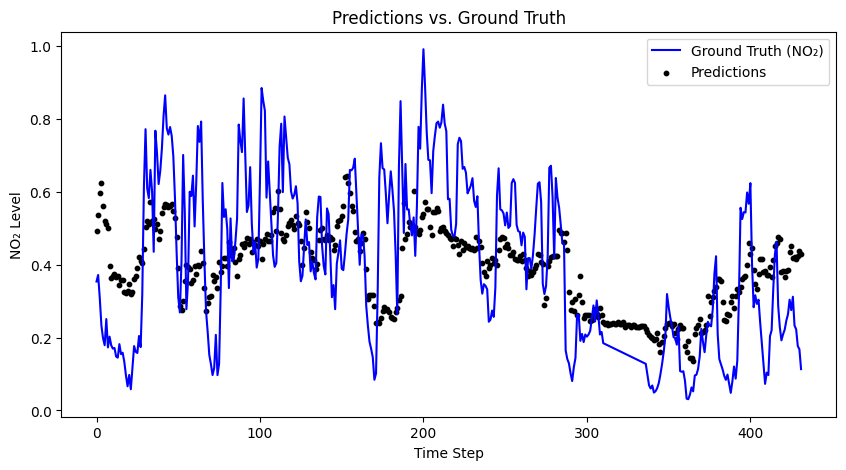

In [23]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
plt.show()
